In [1]:
import os
import torch
from tqdm import tqdm
import numpy as np
import io

import matplotlib.pyplot as plt
from utils import setup_seed
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss
from tensorboardX import SummaryWriter
import cv2
import io


import argparse
import os
import torch
from tqdm import tqdm
import pdb
import numpy as np

import matplotlib.pyplot as plt
from utils import setup_seed, keep_bbox_from_image_range, \
    keep_bbox_from_lidar_range, write_pickle, write_label, \
    iou2d, iou3d_camera, iou_bev
from dataset import Kitti, get_dataloader
from model import PointPillars
from loss import Loss


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Function to plot the scalars and convert the plot to a tensor image
def plot_scalars(scalars, step):
    fig, ax = plt.subplots()
    ax.plot(scalars)
    ax.set_title(f'Step {step}')
    ax.set_xlabel('Scalar Index')
    ax.set_ylabel('Value')
    plt.grid(True)

    # Convert the plot to a PNG image
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)

    # Convert PNG buffer to a tensor image
    image = np.frombuffer(buf.getvalue(), dtype=np.uint8)
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)  # Decode the image
    image = torch.from_numpy(image).permute(2, 0, 1)#.unsqueeze(0)  # Convert to PyTorch tensor and add batch dimension
    return image

def save_summary(writer, loss_dict, global_step, tag, gating_prob, lr=None, momentum=None, model=None, data=None, flag=False):
    for k, v in loss_dict.items():
        writer.add_scalar(f'{tag}/{k}', v, global_step)
    if lr is not None:
        writer.add_scalar('lr', lr, global_step)
    if momentum is not None:
        writer.add_scalar('momentum', momentum, global_step)
    if model is not None and global_step % 1000 == 0:
        for tag, value in model.named_parameters():
            # import pdb
            # pdb.set_trace()
            if value.grad is not None:
                writer.add_histogram(tag + "/grad", value.grad.cpu(), global_step)
    
    if global_step % 100 == 0:
        image = plot_scalars(gating_prob.detach().cpu().numpy(), global_step)
        writer.add_image("Scalars Plot", image, global_step=global_step)
    # for i in data:
    #     del i['gt_names']
    #     del i['image_info']
    #     del i['calib_info']
    #     del i['difficulty']

    # writer.add_graph(model, data)



### Training Arguments

In [3]:
class Args:
    def __init__(self):
        self.data_root = "dataset/KITTI"
        self.saved_path = "logs/pillar_sequence_mem_lin_gat_8_masking_pruning"
        self.saved_path_exact = self.saved_path + "/results_exact"
        self.saved_path_estimate = self.saved_path + "/results_estimate"
        self.batch_size = 1
        self.num_workers = 4
        self.window_length = 1
        self.nclasses = 3
        self.init_lr = 0.00025
        self.max_epoch = 200
        self.log_freq = 1        
        self.ckpt_freq_epoch = 2
        self.val_freq_epoch = 5
        self.no_cuda = not torch.cuda.is_available()
 
args = Args()

### Dataloader

In [4]:
def send_to_cuda(d):
    for key, value in d.items():
        if isinstance(value, np.ndarray):
            # Check if the NumPy array contains a supported type
            if value.dtype in [np.float64, np.float32, np.float16, np.int64, np.int32, np.int16, np.int8, np.uint8, np.bool_]:
                value = torch.tensor(value)
        if isinstance(value, torch.Tensor):
            d[key] = value.cuda()
    return d

# Send all tensors in the list of dictionaries to CUDA
# list_of_dicts_cuda = [send_to_cuda(d) for d in data]

# # Verify that the tensors are on CUDA
# for d in list_of_dicts_cuda:
#     for key, value in d.items():
#         if isinstance(value, torch.Tensor):
#             print(f'{key}: {value.device}')  # Should print 'cuda:0' or another cuda device
#         else:
#             print(f'{key}: {value}')  # Print non-tensor values as is

setup_seed()
train_dataset = Kitti(data_root=args.data_root,
                        split='train',
                        timelength=args.window_length)
val_dataset = Kitti(data_root=args.data_root,
                    split='val',
                    timelength=1)

# data = train_dataset.__getitem__(9)

train_dataset_length = len(train_dataset.sorted_ids)
train_dataset_batch_count =  train_dataset_length // train_dataset.timelength
val_dataset_length = len(val_dataset.sorted_ids)

def get_sequence_from_velodyne_path(file_path):
    parts = file_path.split('/')
    file_name = parts[-1]
    extracted_part = file_name.split('_')[0]
    return extracted_part

# Print the extracted part

CLASSES = Kitti.CLASSES
LABEL2CLASSES = {v:k for k, v in CLASSES.items()}


pcd_limit_range = np.array([0, -40, -3, 70.4, 40, 0.0], dtype=np.float32)


### Model, Loss, Optimizer, Scheduler, Log

In [5]:
if not args.no_cuda:
    pointpillars = PointPillars(nclasses=args.nclasses, window_length=args.window_length).cuda()
else:
    pointpillars = PointPillars(nclasses=args.nclasses, window_length=args.window_length)

model_flag = False

loss_func = Loss()

max_iters = 2* train_dataset_batch_count * args.max_epoch
init_lr = args.init_lr
optimizer = torch.optim.AdamW(params=pointpillars.parameters(), 
                                lr=init_lr, 
                                betas=(0.95, 0.99),
                                weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,  
                                                max_lr=init_lr*10, 
                                                total_steps=max_iters, 
                                                pct_start=0.4, 
                                                anneal_strategy='cos',
                                                cycle_momentum=True, 
                                                base_momentum=0.95*0.895, 
                                                max_momentum=0.95,
                                                div_factor=10)


saved_logs_path = os.path.join(args.saved_path, 'summary')
import shutil
if os.path.exists(saved_logs_path):
    shutil.rmtree(saved_logs_path)
os.makedirs(saved_logs_path, exist_ok=True)
writer = SummaryWriter(saved_logs_path)
saved_ckpt_path = os.path.join(args.saved_path, 'checkpoints')
os.makedirs(saved_ckpt_path, exist_ok=True)

# Directory for exact results
saved_path_exact = args.saved_path_exact
os.makedirs(saved_path_exact, exist_ok=True)
saved_submit_path_exact = os.path.join(saved_path_exact, 'submit')
os.makedirs(saved_submit_path_exact, exist_ok=True)

# Directory for estimate results
saved_path_estimate = args.saved_path_estimate
os.makedirs(saved_path_estimate, exist_ok=True)
saved_submit_path_estimate = os.path.join(saved_path_estimate, 'submit')
os.makedirs(saved_submit_path_estimate, exist_ok=True)


TypeError: __init__() got an unexpected keyword argument 'window_length'

### Validation Stuff

In [ ]:
def get_score_thresholds(tp_scores, total_num_valid_gt, num_sample_pts=41):
    score_thresholds = []
    tp_scores = sorted(tp_scores)[::-1]
    cur_recall, pts_ind = 0, 0
    for i, score in enumerate(tp_scores):
        lrecall = (i + 1) / total_num_valid_gt
        rrecall = (i + 2) / total_num_valid_gt

        if i == len(tp_scores) - 1:
            score_thresholds.append(score)
            break

        if (lrecall + rrecall) / 2 < cur_recall:
            continue

        score_thresholds.append(score)
        pts_ind += 1
        cur_recall = pts_ind / (num_sample_pts - 1)
    return score_thresholds

In [ ]:
def do_eval(det_results, gt_results, CLASSES, saved_path):
    '''
    det_results: list,
    gt_results: dict(id -> det_results)
    CLASSES: dict
    '''
    assert len(det_results) == len(gt_results)
    f = open(os.path.join(saved_path, 'eval_results.txt'), 'w')

    # 1. calculate iou
    ious = {
        'bbox_2d': [],
        'bbox_bev': [],
        'bbox_3d': []
    }
    ids = list(sorted(gt_results.keys()))
    for id in ids:
        gt_result = gt_results[id]['annos']
        det_result = det_results[id]

        # 1.1, 2d bboxes iou
        gt_bboxes2d = gt_result['bbox'].astype(np.float32)
        det_bboxes2d = det_result['bbox'].astype(np.float32)
        iou2d_v = iou2d(torch.from_numpy(gt_bboxes2d).cuda(), torch.from_numpy(det_bboxes2d).cuda())
        ious['bbox_2d'].append(iou2d_v.cpu().numpy())

        # 1.2, bev iou
        gt_location = gt_result['location'].astype(np.float32)
        gt_dimensions = gt_result['dimensions'].astype(np.float32)
        gt_rotation_y = gt_result['rotation_y'].astype(np.float32)
        det_location = det_result['location'].astype(np.float32)
        det_dimensions = det_result['dimensions'].astype(np.float32)
        det_rotation_y = det_result['rotation_y'].astype(np.float32)

        gt_bev = np.concatenate([gt_location[:, [0, 2]], gt_dimensions[:, [0, 2]], gt_rotation_y[:, None]], axis=-1)
        det_bev = np.concatenate([det_location[:, [0, 2]], det_dimensions[:, [0, 2]], det_rotation_y[:, None]], axis=-1)
        iou_bev_v = iou_bev(torch.from_numpy(gt_bev).cuda(), torch.from_numpy(det_bev).cuda())
        ious['bbox_bev'].append(iou_bev_v.cpu().numpy())

        # 1.3, 3dbboxes iou
        gt_bboxes3d = np.concatenate([gt_location, gt_dimensions, gt_rotation_y[:, None]], axis=-1)
        det_bboxes3d = np.concatenate([det_location, det_dimensions, det_rotation_y[:, None]], axis=-1)
        iou3d_v = iou3d_camera(torch.from_numpy(gt_bboxes3d).cuda(), torch.from_numpy(det_bboxes3d).cuda())
        ious['bbox_3d'].append(iou3d_v.cpu().numpy())

    MIN_IOUS = {
        'Pedestrian': [0.5, 0.5, 0.5],
        'Cyclist': [0.5, 0.5, 0.5],
        'Car': [0.7, 0.7, 0.7]
    }
    MIN_HEIGHT = [40, 25, 25]

    overall_results = {}
    for e_ind, eval_type in enumerate(['bbox_2d', 'bbox_bev', 'bbox_3d']):
        eval_ious = ious[eval_type]
        eval_ap_results, eval_aos_results = {}, {}
        for cls in CLASSES:
            eval_ap_results[cls] = []
            eval_aos_results[cls] = []
            CLS_MIN_IOU = MIN_IOUS[cls][e_ind]
            for difficulty in [0, 1, 2]:
                # 1. bbox property
                total_gt_ignores, total_det_ignores, total_dc_bboxes, total_scores = [], [], [], []
                total_gt_alpha, total_det_alpha = [], []
                for id in ids:
                    gt_result = gt_results[id]['annos']
                    det_result = det_results[id]

                    # 1.1 gt bbox property
                    cur_gt_names = gt_result['name']
                    cur_difficulty = gt_result['difficulty']
                    gt_ignores, dc_bboxes = [], []
                    for j, cur_gt_name in enumerate(cur_gt_names):
                        ignore = cur_difficulty[j] < 0 or cur_difficulty[j] > difficulty
                        if cur_gt_name == cls:
                            valid_class = 1
                        elif cls == 'Pedestrian' and cur_gt_name == 'Person_sitting':
                            valid_class = 0
                        elif cls == 'Car' and cur_gt_name == 'Van':
                            valid_class = 0
                        else:
                            valid_class = -1
                        
                        if valid_class == 1 and not ignore:
                            gt_ignores.append(0)
                        elif valid_class == 0 or (valid_class == 1 and ignore):
                            gt_ignores.append(1)
                        else:
                            gt_ignores.append(-1)
                        
                        if cur_gt_name == 'DontCare':
                            dc_bboxes.append(gt_result['bbox'][j])
                    total_gt_ignores.append(gt_ignores)
                    total_dc_bboxes.append(np.array(dc_bboxes))
                    total_gt_alpha.append(gt_result['alpha'])

                    # 1.2 det bbox property
                    cur_det_names = det_result['name']
                    cur_det_heights = det_result['bbox'][:, 3] - det_result['bbox'][:, 1]
                    det_ignores = []
                    for j, cur_det_name in enumerate(cur_det_names):
                        if cur_det_heights[j] < MIN_HEIGHT[difficulty]:
                            det_ignores.append(1)
                        elif cur_det_name == cls:
                            det_ignores.append(0)
                        else:
                            det_ignores.append(-1)
                    total_det_ignores.append(det_ignores)
                    total_scores.append(det_result['score'])
                    total_det_alpha.append(det_result['alpha'])

                # 2. calculate scores thresholds for PR curve
                tp_scores = []
                for i, id in enumerate(ids):
                    cur_eval_ious = eval_ious[i]
                    gt_ignores, det_ignores = total_gt_ignores[i], total_det_ignores[i]
                    scores = total_scores[i]

                    nn, mm = cur_eval_ious.shape
                    assigned = np.zeros((mm, ), dtype=np.bool_)
                    for j in range(nn):
                        if gt_ignores[j] == -1:
                            continue
                        match_id, match_score = -1, -1
                        for k in range(mm):
                            if not assigned[k] and det_ignores[k] >= 0 and cur_eval_ious[j, k] > CLS_MIN_IOU and scores[k] > match_score:
                                match_id = k
                                match_score = scores[k]
                        if match_id != -1:
                            assigned[match_id] = True
                            if det_ignores[match_id] == 0 and gt_ignores[j] == 0:
                                tp_scores.append(match_score)
                total_num_valid_gt = np.sum([np.sum(np.array(gt_ignores) == 0) for gt_ignores in total_gt_ignores])
                score_thresholds = get_score_thresholds(tp_scores, total_num_valid_gt)    
            
                # 3. draw PR curve and calculate mAP
                tps, fns, fps, total_aos = [], [], [], []

                for score_threshold in score_thresholds:
                    tp, fn, fp = 0, 0, 0
                    aos = 0
                    for i, id in enumerate(ids):
                        cur_eval_ious = eval_ious[i]
                        gt_ignores, det_ignores = total_gt_ignores[i], total_det_ignores[i]
                        gt_alpha, det_alpha = total_gt_alpha[i], total_det_alpha[i]
                        scores = total_scores[i]

                        nn, mm = cur_eval_ious.shape
                        assigned = np.zeros((mm, ), dtype=np.bool_)
                        for j in range(nn):
                            if gt_ignores[j] == -1:
                                continue
                            match_id, match_iou = -1, -1
                            for k in range(mm):
                                if not assigned[k] and det_ignores[k] >= 0 and scores[k] >= score_threshold and cur_eval_ious[j, k] > CLS_MIN_IOU:
    
                                    if det_ignores[k] == 0 and cur_eval_ious[j, k] > match_iou:
                                        match_iou = cur_eval_ious[j, k]
                                        match_id = k
                                    elif det_ignores[k] == 1 and match_iou == -1:
                                        match_id = k

                            if match_id != -1:
                                assigned[match_id] = True
                                if det_ignores[match_id] == 0 and gt_ignores[j] == 0:
                                    tp += 1
                                    if eval_type == 'bbox_2d':
                                        aos += (1 + np.cos(gt_alpha[j] - det_alpha[match_id])) / 2
                            else:
                                if gt_ignores[j] == 0:
                                    fn += 1
                            
                        for k in range(mm):
                            if det_ignores[k] == 0 and scores[k] >= score_threshold and not assigned[k]:
                                fp += 1
                        
                        # In case 2d bbox evaluation, we should consider dontcare bboxes
                        if eval_type == 'bbox_2d':
                            dc_bboxes = total_dc_bboxes[i]
                            det_bboxes = det_results[id]['bbox']
                            if len(dc_bboxes) > 0:
                                ious_dc_det = iou2d(torch.from_numpy(det_bboxes), torch.from_numpy(dc_bboxes), metric=1).numpy().T
                                for j in range(len(dc_bboxes)):
                                    for k in range(len(det_bboxes)):
                                        if det_ignores[k] == 0 and scores[k] >= score_threshold and not assigned[k]:
                                            if ious_dc_det[j, k] > CLS_MIN_IOU:
                                                fp -= 1
                                                assigned[k] = True
                            
                    tps.append(tp)
                    fns.append(fn)
                    fps.append(fp)
                    if eval_type == 'bbox_2d':
                        total_aos.append(aos)

                tps, fns, fps = np.array(tps), np.array(fns), np.array(fps)

                precisions = tps / (tps + fns) # actually this is recalls
                # precisions = tps / (tps + fps)
                for i in range(len(score_thresholds)):
                    precisions[i] = np.max(precisions[i:])
                
                sums_AP = 0
                for i in range(0, len(score_thresholds), 4):
                    sums_AP += precisions[i]
                mAP = sums_AP / 11 * 100
                eval_ap_results[cls].append(mAP)

                if eval_type == 'bbox_2d':
                    total_aos = np.array(total_aos)
                    similarity = total_aos / (tps + fps)
                    for i in range(len(score_thresholds)):
                        similarity[i] = np.max(similarity[i:])
                    sums_similarity = 0
                    for i in range(0, len(score_thresholds), 4):
                        sums_similarity += similarity[i]
                    mSimilarity = sums_similarity / 11 * 100
                    eval_aos_results[cls].append(mSimilarity)

        print(f'=========={eval_type.upper()}==========')
        print(f'=========={eval_type.upper()}==========', file=f)
        for k, v in eval_ap_results.items():
            print(f'{k} AP@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
            print(f'{k} AP@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
        if eval_type == 'bbox_2d':
            print(f'==========AOS==========')
            print(f'==========AOS==========', file=f)
            for k, v in eval_aos_results.items():
                print(f'{k} AOS@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
                print(f'{k} AOS@{MIN_IOUS[k][e_ind]}: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
        
        overall_results[eval_type] = np.mean(list(eval_ap_results.values()), 0)
        if eval_type == 'bbox_2d':
            overall_results['AOS'] = np.mean(list(eval_aos_results.values()), 0)
    
    print(f'\n==========Overall==========')
    print(f'\n==========Overall==========', file=f)
    for k, v in overall_results.items():
        print(f'{k} AP: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}')
        print(f'{k} AP: {v[0]:.4f} {v[1]:.4f} {v[2]:.4f}', file=f)
    f.close()
    

In [ ]:
def validation_writer(results, data_cuda):
    # batched_gt_bboxes = [data_cuda[0]['gt_bboxes_3d']]
    # batched_labels = [data_cuda[0]['gt_labels']]
    # batched_difficulty = [data_cuda[0]['difficulty']]
    # batched_gt_bboxes = [data_cuda[0]['gt_bboxes_3d']]

    format_result = {
        'name': [],
        'truncated': [],
        'occluded': [],
        'alpha': [],
        'bbox': [],
        'dimensions': [],
        'location': [],
        'rotation_y': [],
        'score': []
    }

    calib_info = data_cuda[0]['calib_info']
    tr_velo_to_cam = calib_info['Tr_velo_to_cam'].astype(np.float32)
    r0_rect = calib_info['R0_rect'].astype(np.float32)
    P2 = calib_info['P2'].astype(np.float32)

    image_shape = data_cuda[0]['image_info']['image_shape']
    idx = data_cuda[0]['image_info']['image_idx']
    result_filter = keep_bbox_from_image_range(results[0], tr_velo_to_cam, r0_rect, P2, image_shape)
    result_filter = keep_bbox_from_lidar_range(result_filter, pcd_limit_range)

    lidar_bboxes = result_filter['lidar_bboxes']
    labels, scores = result_filter['labels'], result_filter['scores']
    bboxes2d, camera_bboxes = result_filter['bboxes2d'], result_filter['camera_bboxes']

    for lidar_bbox, label, score, bbox2d, camera_bbox in \
        zip(lidar_bboxes, labels, scores, bboxes2d, camera_bboxes):
        format_result['name'].append(LABEL2CLASSES[label])
        format_result['truncated'].append(0.0)
        format_result['occluded'].append(0)
        alpha = camera_bbox[6] - np.arctan2(camera_bbox[0], camera_bbox[2])
        format_result['alpha'].append(alpha)
        format_result['bbox'].append(bbox2d)
        format_result['dimensions'].append(camera_bbox[3:6])
        format_result['location'].append(camera_bbox[:3])
        format_result['rotation_y'].append(camera_bbox[6])
        format_result['score'].append(score)

    return format_result, idx

### Training

In [ ]:
def measure_losses(results, mode=None):
    bbox_cls_pred0 = torch.cat([i['bbox_cls_pred'] for i in results],dim=0)
    bbox_pred0 = torch.cat([i['bbox_pred'] for i in results],dim=0)
    bbox_dir_cls_pred0 = torch.cat([i['bbox_dir_cls_pred'] for i in results],dim=0)
    anchor_target_dict_list = [i['anchor_target_dict']  for i in results]
    y = torch.cat([i['y']  for i in results[1:]],dim=0)
    ye = torch.cat([i['ye']  for i in results[1:]],dim=0)
    # g = torch.cat([i['q']  for i in results[1:]],dim=0)

    # g = g.unsqueeze(-1).unsqueeze(-1)
    # print(y.shape)
    # print(g.shape)
    
    ################# Full features #################
    bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
    bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
    bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)

    batched_bbox_labels = torch.cat([anchor_target_dict['batched_labels'].reshape(-1) for anchor_target_dict in anchor_target_dict_list],dim=0)
    batched_label_weights = torch.cat([anchor_target_dict['batched_label_weights'].reshape(-1) for anchor_target_dict in anchor_target_dict_list],dim=0)
    batched_bbox_reg = torch.cat([anchor_target_dict['batched_bbox_reg'].reshape(-1, 7) for anchor_target_dict in anchor_target_dict_list],dim=0)
    batched_dir_labels = torch.cat([anchor_target_dict['batched_dir_labels'].reshape(-1) for anchor_target_dict in anchor_target_dict_list],dim=0)

    pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

    bbox_pred0 = bbox_pred0[pos_idx]
    batched_bbox_reg = batched_bbox_reg[pos_idx]
    batched_bbox_reg0 = batched_bbox_reg.clone()

    # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
    bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
    batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
    bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
    batched_dir_labels = batched_dir_labels[pos_idx]
    num_cls_pos = (batched_bbox_labels < args.nclasses).sum()
    bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


    batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
    batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

    loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
                            bbox_pred=bbox_pred0,
                            bbox_dir_cls_pred=bbox_dir_cls_pred0,
                            batched_labels=batched_bbox_labels, 
                            num_cls_pos=num_cls_pos, 
                            batched_bbox_reg=batched_bbox_reg0, 
                            batched_dir_labels=batched_dir_labels)

    # gLoss = torch.sum(p*torch.norm(y-ye, dim=(1,2,3)))
    # l2 norm
    # gLoss = (((1-g)*(y-ye)).pow(2).sum(dim=(1,2,3)).pow(0.5)).sum()
    gLoss = (((y-ye)).pow(2).sum(dim=(1,2,3)).pow(0.5)).sum()

    return loss_dict0, gLoss

In [6]:
# # pointpillars.load_state_dict(torch.load("logs/pillar_sequence_memory_gating_binary/checkpoints/epoch_60.pth"))
# checkpoint = torch.load("logs/pillar_sequence_mem_lin_gat_7_optical_flow/checkpoints/epoch_99.pth.tar")
# pointpillars.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch0 = checkpoint['epoch']
# loss = checkpoint['loss']

# training_loss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/train_loss.npy").tolist()
# training_gLoss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/train_gloss.npy").tolist()
# val_loss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/val_loss.npy").tolist()
# val_gLoss0 = np.load("logs/pillar_sequence_memory_linearization/checkpoints/val_gloss.npy").tolist()

training_loss0 = []
training_gLoss0 = []


In [ ]:
pointpillars.eval()

pointpillars.gating_th = 0.006

while (True):

    pointpillars.gating_th += 0.0005

    with torch.no_grad():

        ######################## validation with estimation ##############################
        
        format_results = {}

        first_velodyne_path = val_dataset.data_infos[val_dataset.sorted_ids[0]]['velodyne_path']
        validation_sequence = get_sequence_from_velodyne_path(first_velodyne_path)
        pointpillars.gating_count = 0

        for step in tqdm(range(val_dataset_length)):

            # Load data
            data = val_dataset.__getitem__(step)
            data_cuda = [send_to_cuda(d) for d in data]

            current_velodyne_path = val_dataset.data_infos[val_dataset.sorted_ids[step]]['velodyne_path']
            current_validation_sequence = get_sequence_from_velodyne_path(current_velodyne_path)
            
            if current_validation_sequence != validation_sequence or step==0:
                retain_memory = False
                validation_sequence = current_validation_sequence
            else:
                retain_memory = True

            # Forward Pass
            results = pointpillars(data_cuda, mode='val_estimate', memory=retain_memory)

            try: 
                format_result, idx = validation_writer(results, data_cuda)
                write_label(format_result, os.path.join(saved_submit_path_estimate, f'{idx:06d}.txt'))
                format_results[idx] = {k:np.array(v) for k, v in format_result.items()}
            except:
                None

        try:
            write_pickle(format_results, os.path.join(saved_path_estimate, 'results.pkl'))
        except:
            None

        # print('Evaluating Estimated results.. Please wait several seconds.')
        print(pointpillars.gating_th)
        print("Gating count = " + str(pointpillars.gating_count) + " out of " + str(val_dataset_length))
        print()

        try:
            do_eval(format_results, val_dataset.data_infos, CLASSES, saved_path_estimate)
            
        except:
            print("Validation failed")

    if pointpillars.gating_count > 850:
        break



==================== 0 ====================


  0%|          | 0/1755 [00:00<?, ?it/s]

/home/sayeed/anaconda3/envs/openmmlab/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1755/1755 [19:37<00:00,  1.49it/s]


==================== 1 ====================


100%|██████████| 1755/1755 [19:37<00:00,  1.49it/s]


==================== 2 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 3 ====================


100%|██████████| 1755/1755 [19:40<00:00,  1.49it/s]


==================== 4 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 5 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


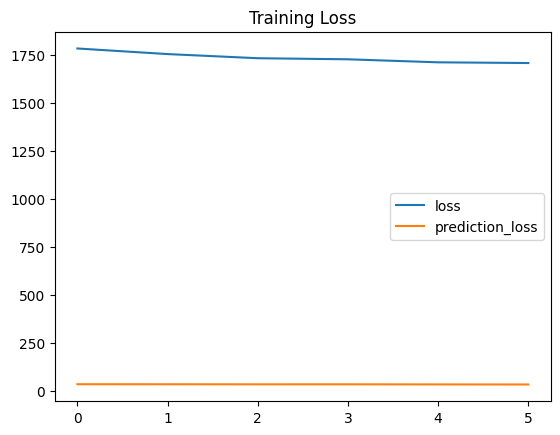

100%|██████████| 866/866 [00:49<00:00, 17.38it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 26.2987 20.1763 20.1763
Cyclist AP@0.5: 18.1818 68.8995 68.8995
Car AP@0.7: 90.3531 86.6711 84.6554
==========AOS==========
Pedestrian AOS@0.5: 8.5660 7.1386 7.1386
Cyclist AOS@0.5: 2.6056 29.0714 29.0714
Car AOS@0.7: 90.3694 88.2807 87.8141
==========BBOX_BEV==========
Pedestrian AP@0.5: 51.5152 40.2597 40.2597
Cyclist AP@0.5: 18.1818 49.7608 49.7608
Car AP@0.7: 87.5217 82.6399 80.1950
==========BBOX_3D==========
Pedestrian AP@0.5: 38.2576 29.2208 29.2208
Cyclist AP@0.5: 18.1818 27.9904 27.9904
Car AP@0.7: 72.3997 65.2315 55.5653

==========Overall==========
bbox_2d AP: 44.9445 58.5823 57.9104
AOS AP: 33.8470 41.4969 41.3414
bbox_bev AP: 52.4062 57.5535 56.7385
bbox_3d AP: 42.9464 40.8142 37.5922


100%|██████████| 866/866 [01:21<00:00, 10.58it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 622 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 10.6061 7.2356 7.2356
Cyclist AP@0.5: 15.9091 37.6794 37.6794
Car AP@0.7: 56.4758 42.8815 41.6961
==========AOS==========
Pedestrian AOS@0.5: 1.9092 1.6227 1.6227
Cyclist AOS@0.5: 0.0292 8.2045 8.2045
Car AOS@0.7: 48.7090 40.2895 40.2403
==========BBOX_BEV==========
Pedestrian AP@0.5: 20.5628 18.3210 18.3210
Cyclist AP@0.5: 13.6364 11.4833 11.4833
Car AP@0.7: 53.5122 36.9618 30.2327
==========BBOX_3D==========
Pedestrian AP@0.5: 12.9870 11.5028 11.5028
Cyclist AP@0.5: 3.4091 2.8708 2.8708
Car AP@0.7: 27.2456 18.1561 13.6249

==========Overall==========
bbox_2d AP: 27.6636 29.2655 28.8704
AOS AP: 16.8824 16.7056 16.6892
bbox_bev AP: 29.2371 22.2553 20.0123
bbox_3d AP: 14.5472 10.8432 9.3328
==================== 6 ====================


100%|██████████| 1755/1755 [19:36<00:00,  1.49it/s]


==================== 7 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 8 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 9 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


==================== 10 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


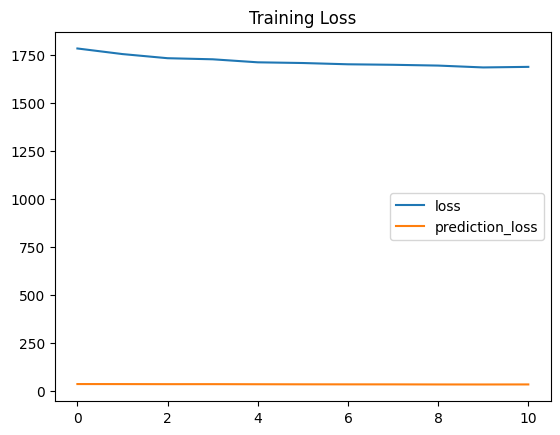

100%|██████████| 866/866 [00:50<00:00, 17.31it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 27.9221 21.1039 21.1039
Cyclist AP@0.5: 18.1818 49.7608 49.7608
Car AP@0.7: 90.4467 85.1108 83.1261
==========AOS==========
Pedestrian AOS@0.5: 13.4669 11.8754 11.8754
Cyclist AOS@0.5: 2.3057 26.4819 26.4819
Car AOS@0.7: 90.4278 86.9176 86.6000
==========BBOX_BEV==========
Pedestrian AP@0.5: 42.8030 38.3117 38.3117
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 87.6166 81.9995 71.6168
==========BBOX_3D==========
Pedestrian AP@0.5: 31.1688 27.8293 27.8293
Cyclist AP@0.5: 18.1818 18.5407 18.5407
Car AP@0.7: 70.5979 54.8245 52.6417

==========Overall==========
bbox_2d AP: 45.5169 51.9918 51.3303
AOS AP: 35.4001 41.7583 41.6524
bbox_bev AP: 49.5338 49.6731 46.2122
bbox_3d AP: 39.9828 33.7315 33.0039


100%|██████████| 866/866 [01:26<00:00,  9.99it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 627 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 18.9394 17.1614 17.1614
Cyclist AP@0.5: 15.9091 27.9904 27.9904
Car AP@0.7: 56.1185 42.2071 40.7711
==========AOS==========
Pedestrian AOS@0.5: 1.4638 1.2995 1.2995
Cyclist AOS@0.5: 0.0123 0.5694 0.5694
Car AOS@0.7: 49.1153 39.6452 39.8027
==========BBOX_BEV==========
Pedestrian AP@0.5: 12.9870 11.6883 11.6883
Cyclist AP@0.5: 15.9091 7.1770 7.1770
Car AP@0.7: 53.4011 36.9315 30.3459
==========BBOX_3D==========
Pedestrian AP@0.5: 11.4719 10.3896 10.3896
Cyclist AP@0.5: 3.4091 2.1531 2.1531
Car AP@0.7: 21.6901 13.5153 12.8547

==========Overall==========
bbox_2d AP: 30.3223 29.1196 28.6410
AOS AP: 16.8638 13.8380 13.8905
bbox_bev AP: 27.4324 18.5989 16.4037
bbox_3d AP: 12.1904 8.6860 8.4658
==================== 11 ====================


100%|██████████| 1755/1755 [19:38<00:00,  1.49it/s]


==================== 12 ====================


100%|██████████| 1755/1755 [19:38<00:00,  1.49it/s]


==================== 13 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 14 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 15 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


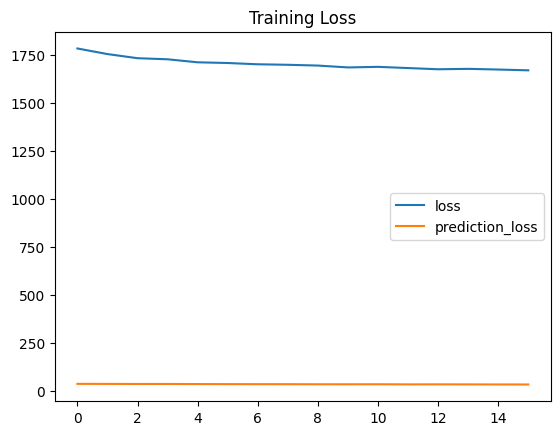

100%|██████████| 866/866 [00:49<00:00, 17.42it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 13.6364 12.8015 12.8015
Cyclist AP@0.5: 18.1818 81.3397 81.3397
Car AP@0.7: 99.6985 86.3973 84.5870
==========AOS==========
Pedestrian AOS@0.5: 3.7474 3.7926 3.7926
Cyclist AOS@0.5: 3.6390 16.0027 16.0027
Car AOS@0.7: 98.7443 88.3119 88.0528
==========BBOX_BEV==========
Pedestrian AP@0.5: 52.8139 41.2338 41.2338
Cyclist AP@0.5: 18.1818 49.7608 49.7608
Car AP@0.7: 87.7177 82.7247 80.3115
==========BBOX_3D==========
Pedestrian AP@0.5: 40.9091 31.1688 31.1688
Cyclist AP@0.5: 18.1818 31.5789 31.5789
Car AP@0.7: 82.6281 67.1030 64.1703

==========Overall==========
bbox_2d AP: 43.8389 60.1795 59.5761
AOS AP: 35.3769 36.0357 35.9494
bbox_bev AP: 52.9045 57.9064 57.1020
bbox_3d AP: 47.2397 43.2836 42.3060


100%|██████████| 866/866 [01:23<00:00, 10.43it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 632 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 30.5195 27.5510 27.5510
Cyclist AP@0.5: 15.9091 65.6699 65.6699
Car AP@0.7: 67.4136 50.0129 42.0920
==========AOS==========
Pedestrian AOS@0.5: 3.9415 3.6656 3.6656
Cyclist AOS@0.5: 0.1769 1.3583 1.3583
Car AOS@0.7: 57.0926 45.0265 42.8724
==========BBOX_BEV==========
Pedestrian AP@0.5: 20.8333 18.5529 18.5529
Cyclist AP@0.5: 3.4091 11.9617 11.9617
Car AP@0.7: 53.7486 36.9105 30.3030
==========BBOX_3D==========
Pedestrian AP@0.5: 18.1277 12.8015 12.8015
Cyclist AP@0.5: 2.2727 5.7416 5.7416
Car AP@0.7: 28.2487 18.4603 17.4384

==========Overall==========
bbox_2d AP: 37.9474 47.7446 45.1043
AOS AP: 20.4037 16.6835 15.9654
bbox_bev AP: 25.9970 22.4750 20.2725
bbox_3d AP: 16.2164 12.3345 11.9938
==================== 16 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 17 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 18 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 19 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 20 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


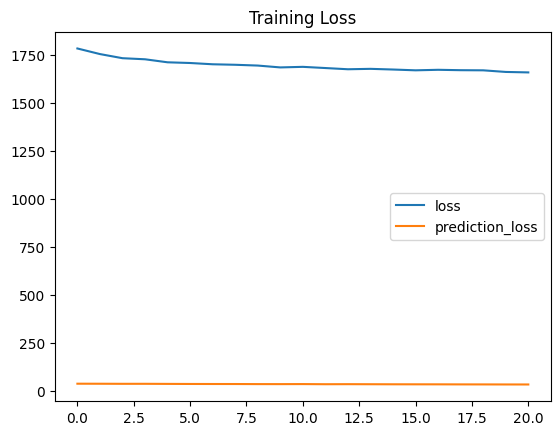

100%|██████████| 866/866 [00:49<00:00, 17.33it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 19.4805 18.5529 18.5529
Cyclist AP@0.5: 18.1818 54.5455 54.5455
Car AP@0.7: 99.6008 85.3696 83.4024
==========AOS==========
Pedestrian AOS@0.5: 7.0526 6.7649 6.7649
Cyclist AOS@0.5: 1.9180 5.9600 5.9600
Car AOS@0.7: 98.9770 88.0115 87.3802
==========BBOX_BEV==========
Pedestrian AP@0.5: 40.5303 31.1688 31.1688
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 87.7368 82.8801 80.4497
==========BBOX_3D==========
Pedestrian AP@0.5: 28.5714 21.5677 21.5677
Cyclist AP@0.5: 18.1818 21.5311 21.5311
Car AP@0.7: 83.7630 65.5756 55.7600

==========Overall==========
bbox_2d AP: 45.7544 52.8227 52.1669
AOS AP: 35.9825 33.5788 33.3684
bbox_bev AP: 48.8163 51.9716 51.1615
bbox_3d AP: 43.5054 36.2248 32.9529


100%|██████████| 866/866 [01:23<00:00, 10.43it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 633 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 26.6234 19.4805 19.4805
Cyclist AP@0.5: 18.1818 49.7608 49.7608
Car AP@0.7: 55.9993 41.4973 39.8209
==========AOS==========
Pedestrian AOS@0.5: 9.9910 8.5362 8.5362
Cyclist AOS@0.5: 0.1880 1.0493 1.0493
Car AOS@0.7: 46.9645 39.0554 38.8103
==========BBOX_BEV==========
Pedestrian AP@0.5: 29.2208 21.3358 21.3358
Cyclist AP@0.5: 13.6364 12.9187 12.9187
Car AP@0.7: 54.2944 37.1272 30.3030
==========BBOX_3D==========
Pedestrian AP@0.5: 17.5866 12.2449 12.2449
Cyclist AP@0.5: 2.2727 3.1100 3.1100
Car AP@0.7: 27.5683 17.7541 13.3933

==========Overall==========
bbox_2d AP: 33.6015 36.9129 36.3541
AOS AP: 19.0478 16.2136 16.1319
bbox_bev AP: 32.3839 23.7939 21.5192
bbox_3d AP: 15.8092 11.0363 9.5827
==================== 21 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 22 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 23 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 24 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 25 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


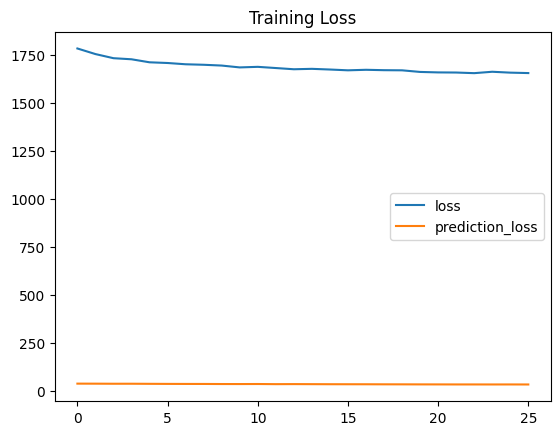

100%|██████████| 866/866 [00:50<00:00, 17.08it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 42.8030 39.6104 39.6104
Cyclist AP@0.5: 18.1818 84.9282 84.9282
Car AP@0.7: 99.3021 86.3585 84.2314
==========AOS==========
Pedestrian AOS@0.5: 5.0883 4.7340 4.7340
Cyclist AOS@0.5: 1.2751 8.3316 8.3316
Car AOS@0.7: 98.0023 88.4763 87.9001
==========BBOX_BEV==========
Pedestrian AP@0.5: 26.6234 20.8720 20.8720
Cyclist AP@0.5: 18.1818 68.8995 68.8995
Car AP@0.7: 87.1023 82.5788 79.9540
==========BBOX_3D==========
Pedestrian AP@0.5: 20.8333 19.2486 19.2486
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 81.2302 66.2825 56.3204

==========Overall==========
bbox_2d AP: 53.4290 70.2990 69.5900
AOS AP: 34.7886 33.8473 33.6553
bbox_bev AP: 43.9692 57.4501 56.5752
bbox_3d AP: 40.0818 41.9075 38.5868


100%|██████████| 866/866 [01:23<00:00, 10.42it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 639 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 40.1515 31.1688 31.1688
Cyclist AP@0.5: 15.9091 42.7033 42.7033
Car AP@0.7: 56.9612 42.6411 41.0308
==========AOS==========
Pedestrian AOS@0.5: 2.3511 1.9556 1.9556
Cyclist AOS@0.5: 0.1026 1.4790 1.4790
Car AOS@0.7: 50.1702 42.0781 42.0865
==========BBOX_BEV==========
Pedestrian AP@0.5: 18.6688 13.3581 13.3581
Cyclist AP@0.5: 11.3636 12.9187 12.9187
Car AP@0.7: 52.5453 30.6432 29.0340
==========BBOX_3D==========
Pedestrian AP@0.5: 11.2554 7.3748 7.3748
Cyclist AP@0.5: 4.5455 5.7416 5.7416
Car AP@0.7: 26.4086 17.4964 13.2648

==========Overall==========
bbox_2d AP: 37.6739 38.8377 38.3010
AOS AP: 17.5413 15.1709 15.1737
bbox_bev AP: 27.5259 18.9733 18.4369
bbox_3d AP: 14.0698 10.2043 8.7937
==================== 26 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 27 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 28 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 29 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.49it/s]


==================== 30 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


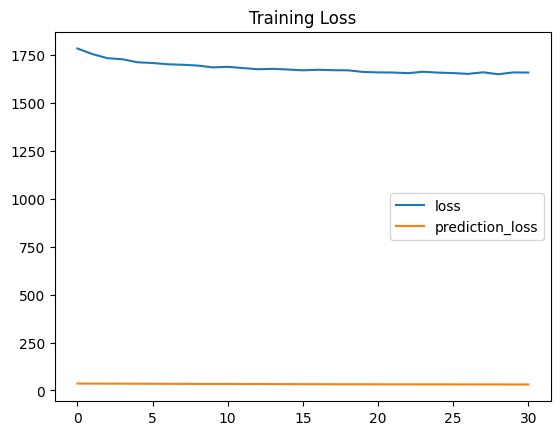

100%|██████████| 866/866 [00:50<00:00, 17.20it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 28.8961 26.7161 26.7161
Cyclist AP@0.5: 18.1818 80.1435 80.1435
Car AP@0.7: 90.2611 86.4441 84.4453
==========AOS==========
Pedestrian AOS@0.5: 3.9414 4.4205 4.4205
Cyclist AOS@0.5: 6.0744 10.3712 10.3712
Car AOS@0.7: 90.2260 88.6957 87.9844
==========BBOX_BEV==========
Pedestrian AP@0.5: 29.5455 27.2727 27.2727
Cyclist AP@0.5: 18.1818 42.7033 42.7033
Car AP@0.7: 87.1404 82.7718 80.2085
==========BBOX_3D==========
Pedestrian AP@0.5: 18.3983 17.3933 17.3933
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 69.2689 56.6577 54.3428

==========Overall==========
bbox_2d AP: 45.7797 64.4346 63.7683
AOS AP: 33.4139 34.4958 34.2587
bbox_bev AP: 44.9559 50.9160 50.0615
bbox_3d AP: 35.2830 34.2530 33.4814


100%|██████████| 866/866 [01:22<00:00, 10.46it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 643 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 30.5195 26.4378 26.4378
Cyclist AP@0.5: 11.3636 49.7608 49.7608
Car AP@0.7: 41.2517 37.1694 31.0782
==========AOS==========
Pedestrian AOS@0.5: 1.2458 1.1036 1.1036
Cyclist AOS@0.5: 0.3597 1.6958 1.6958
Car AOS@0.7: 34.0075 31.3340 29.7460
==========BBOX_BEV==========
Pedestrian AP@0.5: 27.9221 20.4082 20.4082
Cyclist AP@0.5: 4.5455 12.9187 12.9187
Car AP@0.7: 40.4151 27.7528 26.4321
==========BBOX_3D==========
Pedestrian AP@0.5: 12.9870 11.5028 11.5028
Cyclist AP@0.5: 3.4091 6.1005 6.1005
Car AP@0.7: 18.8756 12.2931 11.6745

==========Overall==========
bbox_2d AP: 27.7116 37.7893 35.7589
AOS AP: 11.8710 11.3778 10.8484
bbox_bev AP: 24.2942 20.3599 19.9196
bbox_3d AP: 11.7572 9.9655 9.7593
==================== 31 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 32 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 33 ====================


100%|██████████| 1755/1755 [19:34<00:00,  1.49it/s]


==================== 34 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 35 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


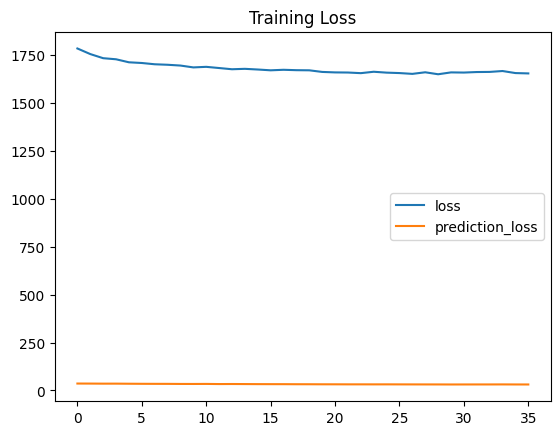

100%|██████████| 866/866 [00:49<00:00, 17.37it/s]


Evaluating Exact results.. Please wait several seconds.
Validation failed


100%|██████████| 866/866 [01:22<00:00, 10.48it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 642 out of 866
Validation failed
==================== 36 ====================


100%|██████████| 1755/1755 [19:32<00:00,  1.50it/s]


==================== 37 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


==================== 38 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 39 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 40 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


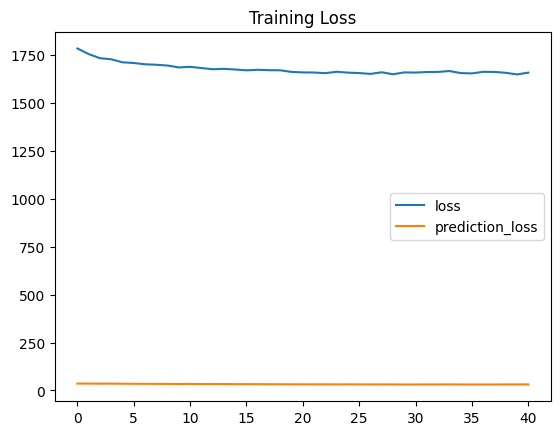

100%|██████████| 866/866 [00:51<00:00, 16.90it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 30.1948 27.8293 27.8293
Cyclist AP@0.5: 18.1818 82.5359 82.5359
Car AP@0.7: 99.8014 85.4732 83.3564
==========AOS==========
Pedestrian AOS@0.5: 7.4968 7.2473 7.2473
Cyclist AOS@0.5: 0.6361 31.4727 31.4727
Car AOS@0.7: 98.2008 87.4914 86.7214
==========BBOX_BEV==========
Pedestrian AP@0.5: 50.2165 40.2597 40.2597
Cyclist AP@0.5: 18.1818 31.5789 31.5789
Car AP@0.7: 87.2980 82.7811 71.9121
==========BBOX_3D==========
Pedestrian AP@0.5: 37.8788 30.0557 30.0557
Cyclist AP@0.5: 18.1818 18.5407 18.5407
Car AP@0.7: 70.8821 56.0331 53.6814

==========Overall==========
bbox_2d AP: 49.3927 65.2795 64.5739
AOS AP: 35.4446 42.0705 41.8138
bbox_bev AP: 51.8988 51.5399 47.9169
bbox_3d AP: 42.3142 34.8765 34.0926


100%|██████████| 866/866 [01:22<00:00, 10.52it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 647 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 12.1212 10.7607 10.7607
Cyclist AP@0.5: 15.9091 57.2121 57.2121
Car AP@0.7: 40.3931 29.8112 29.2011
==========AOS==========
Pedestrian AOS@0.5: 2.5820 2.3440 2.3440
Cyclist AOS@0.5: 0.0535 14.6993 14.6993
Car AOS@0.7: 34.7393 27.9679 28.4132
==========BBOX_BEV==========
Pedestrian AP@0.5: 13.4199 12.2449 12.2449
Cyclist AP@0.5: 13.6364 13.3971 13.3971
Car AP@0.7: 41.8182 28.2174 26.6250
==========BBOX_3D==========
Pedestrian AP@0.5: 6.8182 6.1224 6.1224
Cyclist AP@0.5: 1.1364 2.3923 2.3923
Car AP@0.7: 18.5401 11.6743 11.0137

==========Overall==========
bbox_2d AP: 22.8078 32.5947 32.3913
AOS AP: 12.4583 15.0038 15.1522
bbox_bev AP: 22.9582 17.9532 17.4223
bbox_3d AP: 8.8315 6.7297 6.5095
==================== 41 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


==================== 42 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 43 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 44 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


==================== 45 ====================


100%|██████████| 1755/1755 [19:36<00:00,  1.49it/s]


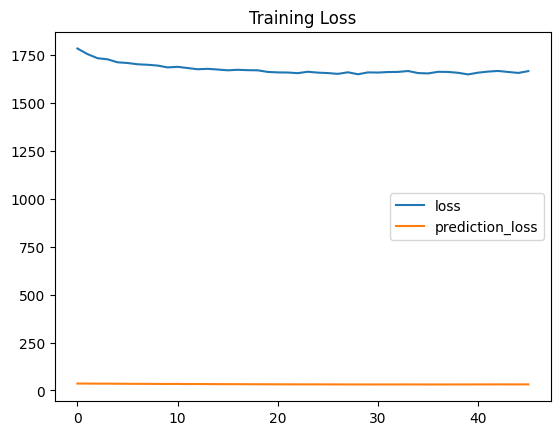

100%|██████████| 866/866 [00:50<00:00, 17.28it/s]


Evaluating Exact results.. Please wait several seconds.
Validation failed


100%|██████████| 866/866 [01:23<00:00, 10.33it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 650 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 28.2468 20.8720 20.8720
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 54.4012 40.3811 38.7659
==========AOS==========
Pedestrian AOS@0.5: 3.1788 2.8376 2.8376
Cyclist AOS@0.5: 0.0646 0.5945 0.5945
Car AOS@0.7: 48.7787 40.2206 39.2525
==========BBOX_BEV==========
Pedestrian AP@0.5: 26.6234 19.9443 19.9443
Cyclist AP@0.5: 13.6364 13.3971 13.3971
Car AP@0.7: 50.3552 29.4372 27.7406
==========BBOX_3D==========
Pedestrian AP@0.5: 12.1212 10.7607 10.7607
Cyclist AP@0.5: 2.2727 5.3828 5.3828
Car AP@0.7: 19.8976 12.6706 11.8095

==========Overall==========
bbox_2d AP: 33.6099 33.8148 33.2764
AOS AP: 17.3407 14.5509 14.2282
bbox_bev AP: 30.2050 20.9262 20.3607
bbox_3d AP: 11.4305 9.6047 9.3176
==================== 46 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 47 ====================


100%|██████████| 1755/1755 [19:35<00:00,  1.49it/s]


==================== 48 ====================


100%|██████████| 1755/1755 [19:32<00:00,  1.50it/s]


==================== 49 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 50 ====================


100%|██████████| 1755/1755 [19:37<00:00,  1.49it/s]


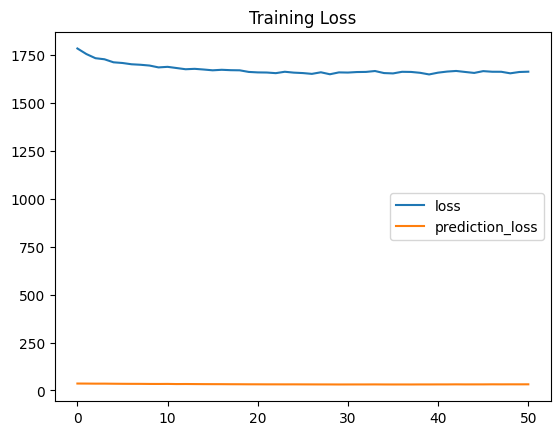

100%|██████████| 866/866 [00:50<00:00, 17.12it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 19.3250 18.0891 18.0891
Cyclist AP@0.5: 18.1818 69.9761 69.9761
Car AP@0.7: 99.6000 86.2656 84.6189
==========AOS==========
Pedestrian AOS@0.5: 12.5517 12.0610 12.0610
Cyclist AOS@0.5: 0.9013 47.2748 47.2748
Car AOS@0.7: 98.1570 88.3867 88.1419
==========BBOX_BEV==========
Pedestrian AP@0.5: 54.0011 42.5325 42.5325
Cyclist AP@0.5: 18.1818 50.7177 50.7177
Car AP@0.7: 86.0196 81.1578 71.0331
==========BBOX_3D==========
Pedestrian AP@0.5: 30.0490 27.5510 27.5510
Cyclist AP@0.5: 18.1818 20.9330 20.9330
Car AP@0.7: 72.1399 65.2874 55.8310

==========Overall==========
bbox_2d AP: 45.7023 58.1102 57.5613
AOS AP: 37.2034 49.2408 49.1592
bbox_bev AP: 52.7342 58.1360 54.7611
bbox_3d AP: 40.1236 37.9238 34.7717


100%|██████████| 866/866 [01:23<00:00, 10.41it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 649 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 27.2727 20.1763 20.1763
Cyclist AP@0.5: 15.9091 41.0287 41.0287
Car AP@0.7: 52.4686 40.3090 39.3435
==========AOS==========
Pedestrian AOS@0.5: 1.4125 1.2066 1.2066
Cyclist AOS@0.5: 0.2132 27.3017 27.3017
Car AOS@0.7: 44.3748 37.5661 37.6031
==========BBOX_BEV==========
Pedestrian AP@0.5: 27.9221 20.8720 20.8720
Cyclist AP@0.5: 15.9091 12.9187 12.9187
Car AP@0.7: 41.9594 28.1844 26.9839
==========BBOX_3D==========
Pedestrian AP@0.5: 13.4199 11.8738 11.8738
Cyclist AP@0.5: 2.2727 2.3923 2.3923
Car AP@0.7: 20.0919 12.6294 12.0479

==========Overall==========
bbox_2d AP: 31.8835 33.8380 33.5162
AOS AP: 15.3335 22.0248 22.0371
bbox_bev AP: 28.5969 20.6583 20.2582
bbox_3d AP: 11.9282 8.9652 8.7713
==================== 51 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


==================== 52 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


==================== 53 ====================


100%|██████████| 1755/1755 [19:36<00:00,  1.49it/s]


==================== 54 ====================


100%|██████████| 1755/1755 [19:34<00:00,  1.49it/s]


==================== 55 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


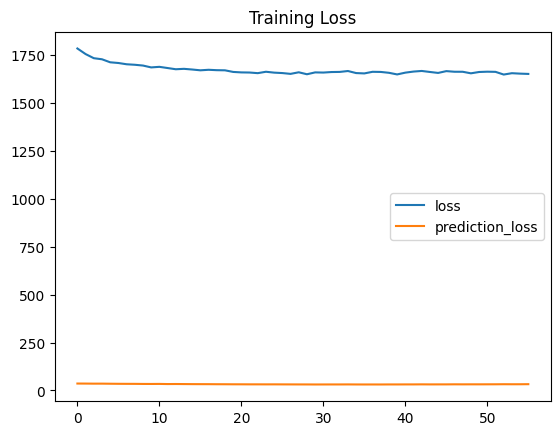

100%|██████████| 866/866 [00:49<00:00, 17.35it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 29.5455 26.7161 26.7161
Cyclist AP@0.5: 18.1818 87.3206 87.3206
Car AP@0.7: 90.1752 84.3860 82.3432
==========AOS==========
Pedestrian AOS@0.5: 3.6559 3.5000 3.5000
Cyclist AOS@0.5: 6.3670 14.0933 14.0933
Car AOS@0.7: 90.2290 85.9751 84.4875
==========BBOX_BEV==========
Pedestrian AP@0.5: 53.2468 42.2078 42.2078
Cyclist AP@0.5: 18.1818 66.7464 66.7464
Car AP@0.7: 84.6426 71.3872 69.1001
==========BBOX_3D==========
Pedestrian AP@0.5: 40.9091 37.3377 37.3377
Cyclist AP@0.5: 18.1818 31.5789 31.5789
Car AP@0.7: 52.5574 41.2552 39.7003

==========Overall==========
bbox_2d AP: 45.9675 66.1409 65.4600
AOS AP: 33.4173 34.5228 34.0270
bbox_bev AP: 52.0237 60.1138 59.3514
bbox_3d AP: 37.2161 36.7239 36.2056


100%|██████████| 866/866 [01:22<00:00, 10.47it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 653 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 19.2100 13.1725 13.1725
Cyclist AP@0.5: 13.6364 67.8230 67.8230
Car AP@0.7: 30.8253 27.7534 27.2865
==========AOS==========
Pedestrian AOS@0.5: 1.6766 1.4787 1.4787
Cyclist AOS@0.5: 0.1698 1.3450 1.3450
Car AOS@0.7: 28.4451 24.8792 24.6992
==========BBOX_BEV==========
Pedestrian AP@0.5: 20.0216 17.3933 17.3933
Cyclist AP@0.5: 4.5455 12.4402 12.4402
Car AP@0.7: 39.9621 26.8241 25.9648
==========BBOX_3D==========
Pedestrian AP@0.5: 12.1212 10.5751 10.5751
Cyclist AP@0.5: 3.4091 6.1005 6.1005
Car AP@0.7: 10.8195 6.6289 6.4778

==========Overall==========
bbox_2d AP: 21.2239 36.2496 36.0940
AOS AP: 10.0972 9.2343 9.1743
bbox_bev AP: 21.5097 18.8859 18.5995
bbox_3d AP: 8.7833 7.7682 7.7178
==================== 56 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 57 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 58 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 59 ====================


100%|██████████| 1755/1755 [19:32<00:00,  1.50it/s]


==================== 60 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


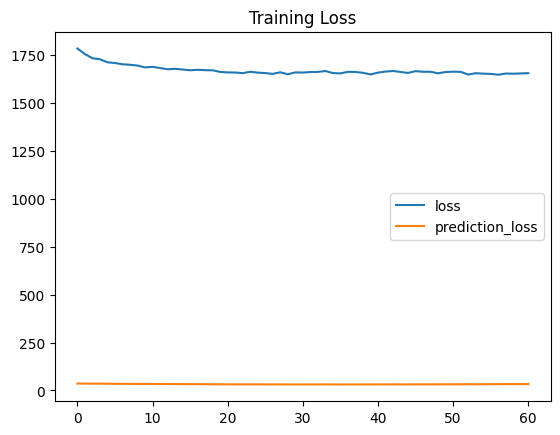

100%|██████████| 866/866 [00:51<00:00, 16.88it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 27.9221 26.1596 26.1596
Cyclist AP@0.5: 18.1818 69.9761 69.9761
Car AP@0.7: 99.7000 85.5402 83.5592
==========AOS==========
Pedestrian AOS@0.5: 4.6033 4.1836 4.1836
Cyclist AOS@0.5: 5.0686 23.0932 23.0932
Car AOS@0.7: 99.6863 89.5797 88.1455
==========BBOX_BEV==========
Pedestrian AP@0.5: 40.1515 37.0130 37.0130
Cyclist AP@0.5: 18.1818 50.7177 50.7177
Car AP@0.7: 87.0039 81.3996 71.0167
==========BBOX_3D==========
Pedestrian AP@0.5: 21.6450 20.4082 20.4082
Cyclist AP@0.5: 18.1818 30.8612 30.8612
Car AP@0.7: 68.8480 54.8753 52.6924

==========Overall==========
bbox_2d AP: 48.6013 60.5586 59.8983
AOS AP: 36.4527 38.9522 38.4741
bbox_bev AP: 48.4457 56.3767 52.9158
bbox_3d AP: 36.2249 35.3816 34.6539


100%|██████████| 866/866 [01:21<00:00, 10.57it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 651 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 10.8225 7.3748 7.3748
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 42.4876 37.0281 31.0549
==========AOS==========
Pedestrian AOS@0.5: 1.0626 0.9111 0.9111
Cyclist AOS@0.5: 0.6204 3.1444 3.1444
Car AOS@0.7: 41.9139 38.1111 36.2573
==========BBOX_BEV==========
Pedestrian AP@0.5: 20.5628 18.7848 18.7848
Cyclist AP@0.5: 13.6364 12.4402 12.4402
Car AP@0.7: 38.9662 26.7780 21.1219
==========BBOX_3D==========
Pedestrian AP@0.5: 6.8182 6.2616 6.2616
Cyclist AP@0.5: 4.5455 6.4593 6.4593
Car AP@0.7: 12.2409 10.2601 7.3305

==========Overall==========
bbox_2d AP: 23.8306 28.1981 26.2070
AOS AP: 14.5323 14.0555 13.4376
bbox_bev AP: 24.3884 19.3343 17.4490
bbox_3d AP: 7.8682 7.6603 6.6838
==================== 61 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


==================== 62 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 63 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 64 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 65 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


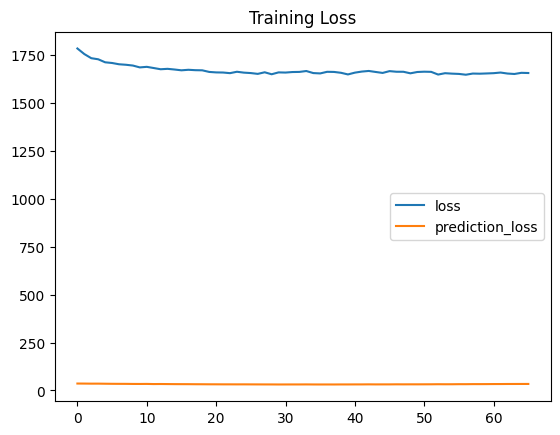

100%|██████████| 866/866 [00:49<00:00, 17.33it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 12.7706 12.8015 12.8015
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 99.8999 86.7413 84.7465
==========AOS==========
Pedestrian AOS@0.5: 0.9144 0.9498 0.9498
Cyclist AOS@0.5: 1.7325 54.5496 54.5496
Car AOS@0.7: 98.6243 87.4415 87.0080
==========BBOX_BEV==========
Pedestrian AP@0.5: 30.1948 26.7161 26.7161
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 87.3672 83.1377 72.4258
==========BBOX_3D==========
Pedestrian AP@0.5: 20.5628 18.3210 18.3210
Cyclist AP@0.5: 18.1818 30.8612 30.8612
Car AP@0.7: 72.4185 64.8291 55.1266

==========Overall==========
bbox_2d AP: 43.6174 55.0709 54.4060
AOS AP: 33.7570 47.6470 47.5025
bbox_bev AP: 45.2479 50.5733 47.0027
bbox_3d AP: 37.0544 38.0038 34.7696


100%|██████████| 866/866 [01:21<00:00, 10.63it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 652 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 3.0303 2.7829 2.7829
Cyclist AP@0.5: 18.1818 52.6316 52.6316
Car AP@0.7: 53.4204 40.1800 38.8585
==========AOS==========
Pedestrian AOS@0.5: 0.3342 0.3032 0.3032
Cyclist AOS@0.5: 0.0839 4.4244 4.4244
Car AOS@0.7: 43.5208 34.7886 33.6814
==========BBOX_BEV==========
Pedestrian AP@0.5: 12.3377 10.9462 10.9462
Cyclist AP@0.5: 18.1818 17.9426 17.9426
Car AP@0.7: 42.2348 28.8533 27.3417
==========BBOX_3D==========
Pedestrian AP@0.5: 6.1688 5.5659 5.5659
Cyclist AP@0.5: 13.6364 7.1770 7.1770
Car AP@0.7: 19.5770 12.4510 11.7420

==========Overall==========
bbox_2d AP: 24.8775 31.8648 31.4243
AOS AP: 14.6463 13.1721 12.8030
bbox_bev AP: 24.2514 19.2474 18.7435
bbox_3d AP: 13.1274 8.3980 8.1616
==================== 66 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


==================== 67 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


==================== 68 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 69 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 70 ====================


100%|██████████| 1755/1755 [19:35<00:00,  1.49it/s]


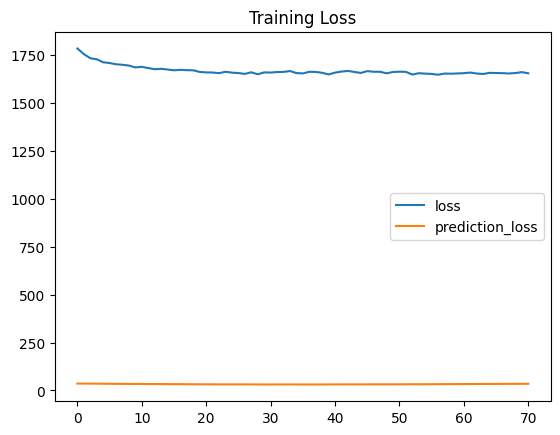

100%|██████████| 866/866 [00:50<00:00, 17.02it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 37.1212 28.9425 28.9425
Cyclist AP@0.5: 18.1818 68.8995 68.8995
Car AP@0.7: 90.6271 85.1296 82.8550
==========AOS==========
Pedestrian AOS@0.5: 21.9276 20.0215 20.0215
Cyclist AOS@0.5: 4.4539 29.1359 29.1359
Car AOS@0.7: 90.3947 87.9449 86.8309
==========BBOX_BEV==========
Pedestrian AP@0.5: 42.4242 37.9870 37.9870
Cyclist AP@0.5: 18.1818 49.7608 49.7608
Car AP@0.7: 87.0367 81.2135 70.5171
==========BBOX_3D==========
Pedestrian AP@0.5: 37.5000 28.9425 28.9425
Cyclist AP@0.5: 15.9091 26.5550 26.5550
Car AP@0.7: 72.0230 55.8419 53.1341

==========Overall==========
bbox_2d AP: 48.6434 60.9906 60.2323
AOS AP: 38.9254 45.7008 45.3294
bbox_bev AP: 49.2143 56.3204 52.7550
bbox_3d AP: 41.8107 37.1131 36.2105


100%|██████████| 866/866 [01:23<00:00, 10.37it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 656 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 18.3983 13.3581 13.3581
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 53.8776 39.5871 38.0400
==========AOS==========
Pedestrian AOS@0.5: 4.9594 4.1847 4.1847
Cyclist AOS@0.5: 1.1924 5.2799 5.2799
Car AOS@0.7: 44.9580 36.5583 33.9092
==========BBOX_BEV==========
Pedestrian AP@0.5: 18.6688 13.3581 13.3581
Cyclist AP@0.5: 18.1818 13.3971 13.3971
Car AP@0.7: 50.8582 29.8000 28.1694
==========BBOX_3D==========
Pedestrian AP@0.5: 7.3052 6.5399 6.5399
Cyclist AP@0.5: 3.4091 5.0239 5.0239
Car AP@0.7: 20.7637 12.8633 12.0723

==========Overall==========
bbox_2d AP: 30.1525 31.6037 31.0880
AOS AP: 17.0366 15.3410 14.4579
bbox_bev AP: 29.2363 18.8517 18.3082
bbox_3d AP: 10.4927 8.1424 7.8787
==================== 71 ====================


100%|██████████| 1755/1755 [19:41<00:00,  1.48it/s]


==================== 72 ====================


100%|██████████| 1755/1755 [19:39<00:00,  1.49it/s]


==================== 73 ====================


100%|██████████| 1755/1755 [19:38<00:00,  1.49it/s]


==================== 74 ====================


100%|██████████| 1755/1755 [19:42<00:00,  1.48it/s]


==================== 75 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


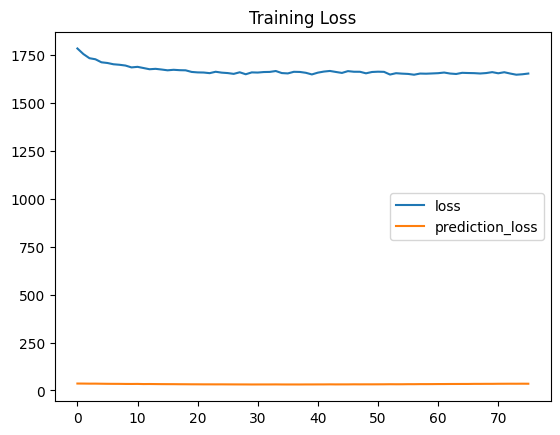

100%|██████████| 866/866 [00:50<00:00, 17.29it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 27.2727 21.1039 21.1039
Cyclist AP@0.5: 18.1818 54.5455 54.5455
Car AP@0.7: 98.8083 83.6280 81.6610
==========AOS==========
Pedestrian AOS@0.5: 5.4740 5.1916 5.1916
Cyclist AOS@0.5: 15.9033 21.0977 21.0977
Car AOS@0.7: 97.5909 84.4638 81.4689
==========BBOX_BEV==========
Pedestrian AP@0.5: 29.2208 26.7161 26.7161
Cyclist AP@0.5: 18.1818 42.7033 42.7033
Car AP@0.7: 87.3953 83.2684 80.6951
==========BBOX_3D==========
Pedestrian AP@0.5: 18.3983 17.1614 17.1614
Cyclist AP@0.5: 18.1818 30.1435 30.1435
Car AP@0.7: 82.8163 65.3707 55.7428

==========Overall==========
bbox_2d AP: 48.0876 53.0925 52.4368
AOS AP: 39.6561 36.9177 35.9194
bbox_bev AP: 44.9326 50.8960 50.0382
bbox_3d AP: 39.7988 37.5585 34.3493


100%|██████████| 866/866 [01:22<00:00, 10.55it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 653 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 17.5866 12.8015 12.8015
Cyclist AP@0.5: 15.9091 42.7033 42.7033
Car AP@0.7: 51.9686 38.3994 36.8014
==========AOS==========
Pedestrian AOS@0.5: 1.5241 1.3249 1.3249
Cyclist AOS@0.5: 2.3535 3.3852 3.3852
Car AOS@0.7: 44.4612 31.9551 31.9889
==========BBOX_BEV==========
Pedestrian AP@0.5: 26.2987 19.4805 19.4805
Cyclist AP@0.5: 11.3636 10.5263 10.5263
Car AP@0.7: 40.0394 27.2882 21.4039
==========BBOX_3D==========
Pedestrian AP@0.5: 11.9048 10.7607 10.7607
Cyclist AP@0.5: 2.2727 5.3828 5.3828
Car AP@0.7: 19.1859 11.6876 11.0616

==========Overall==========
bbox_2d AP: 28.4881 31.3014 30.7687
AOS AP: 16.1129 12.2217 12.2330
bbox_bev AP: 25.9006 19.0984 17.1369
bbox_3d AP: 11.1211 9.2770 9.0683
==================== 76 ====================


100%|██████████| 1755/1755 [19:16<00:00,  1.52it/s]


==================== 77 ====================


100%|██████████| 1755/1755 [19:19<00:00,  1.51it/s]


==================== 78 ====================


100%|██████████| 1755/1755 [19:23<00:00,  1.51it/s]


==================== 79 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 80 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


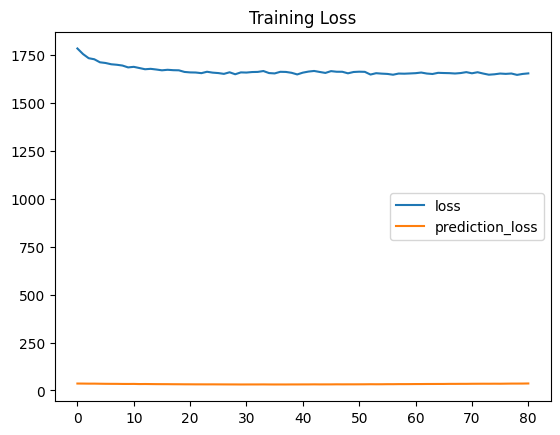

100%|██████████| 866/866 [00:50<00:00, 17.03it/s]


Evaluating Exact results.. Please wait several seconds.
Validation failed


100%|██████████| 866/866 [01:21<00:00, 10.57it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 654 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 11.2554 10.5751 10.5751
Cyclist AP@0.5: 18.1818 64.5933 64.5933
Car AP@0.7: 29.2110 21.1674 20.5131
==========AOS==========
Pedestrian AOS@0.5: 6.1266 5.7694 5.7694
Cyclist AOS@0.5: 0.5278 6.3379 6.3379
Car AOS@0.7: 23.2942 18.3937 18.3395
==========BBOX_BEV==========
Pedestrian AP@0.5: 19.7511 17.8571 17.8571
Cyclist AP@0.5: 15.9091 27.2727 27.2727
Car AP@0.7: 26.4017 18.8061 18.0441
==========BBOX_3D==========
Pedestrian AP@0.5: 12.5541 11.3173 11.3173
Cyclist AP@0.5: 4.5455 7.5359 7.5359
Car AP@0.7: 10.7504 6.9303 6.5119

==========Overall==========
bbox_2d AP: 19.5494 32.1120 31.8938
AOS AP: 9.9828 10.1670 10.1490
bbox_bev AP: 20.6873 21.3120 21.0580
bbox_3d AP: 9.2833 8.5945 8.4550
==================== 81 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


==================== 82 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


==================== 83 ====================


100%|██████████| 1755/1755 [19:35<00:00,  1.49it/s]


==================== 84 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 85 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


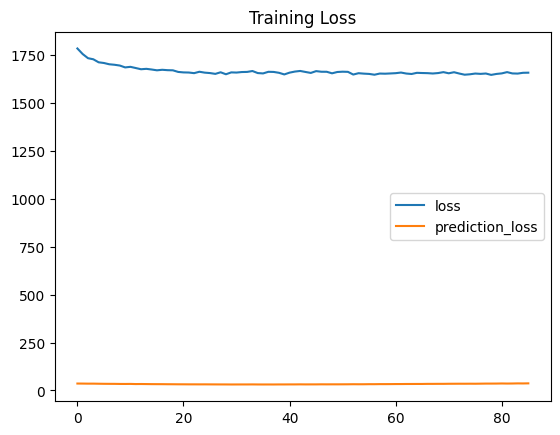

100%|██████████| 866/866 [00:49<00:00, 17.32it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 21.6450 20.1763 20.1763
Cyclist AP@0.5: 18.1818 54.5455 54.5455
Car AP@0.7: 90.4462 85.8586 82.7162
==========AOS==========
Pedestrian AOS@0.5: 3.9432 5.1195 5.1195
Cyclist AOS@0.5: 11.6802 19.2980 19.2980
Car AOS@0.7: 89.7077 87.5474 84.6936
==========BBOX_BEV==========
Pedestrian AP@0.5: 51.0823 40.5844 40.5844
Cyclist AP@0.5: 18.1818 39.3541 39.3541
Car AP@0.7: 87.4161 82.3131 71.2314
==========BBOX_3D==========
Pedestrian AP@0.5: 41.2879 37.6623 37.6623
Cyclist AP@0.5: 18.1818 29.4258 29.4258
Car AP@0.7: 69.2749 55.5930 52.3592

==========Overall==========
bbox_2d AP: 43.4244 53.5268 52.4793
AOS AP: 35.1104 37.3216 36.3704
bbox_bev AP: 52.2267 54.0839 50.3900
bbox_3d AP: 42.9149 40.8937 39.8158


100%|██████████| 866/866 [01:21<00:00, 10.58it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 651 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 19.4805 18.3210 18.3210
Cyclist AP@0.5: 13.6364 42.4242 42.4242
Car AP@0.7: 41.6659 31.1024 29.8248
==========AOS==========
Pedestrian AOS@0.5: 0.6686 0.6144 0.6144
Cyclist AOS@0.5: 0.1221 1.3970 1.3970
Car AOS@0.7: 32.5370 26.3623 26.5793
==========BBOX_BEV==========
Pedestrian AP@0.5: 28.5714 26.1596 26.1596
Cyclist AP@0.5: 4.5455 7.5359 7.5359
Car AP@0.7: 50.2599 29.6281 28.1000
==========BBOX_3D==========
Pedestrian AP@0.5: 17.8571 13.3581 13.3581
Cyclist AP@0.5: 2.2727 5.7416 5.7416
Car AP@0.7: 13.7856 11.4268 10.6650

==========Overall==========
bbox_2d AP: 24.9276 30.6159 30.1900
AOS AP: 11.1092 9.4579 9.5303
bbox_bev AP: 27.7923 21.1078 20.5985
bbox_3d AP: 11.3052 10.1755 9.9216
==================== 86 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 87 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 88 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 89 ====================


100%|██████████| 1755/1755 [19:35<00:00,  1.49it/s]


==================== 90 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


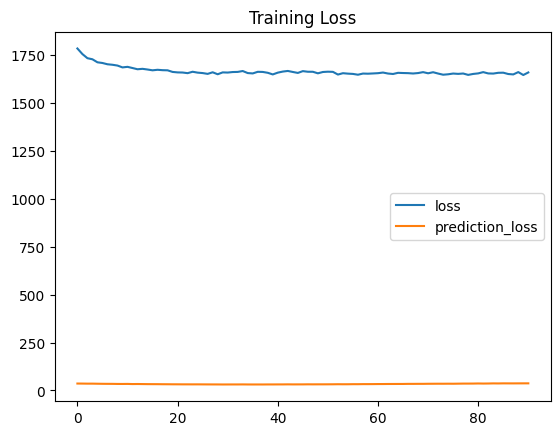

100%|██████████| 866/866 [00:50<00:00, 17.06it/s]


Evaluating Exact results.. Please wait several seconds.
Validation failed


100%|██████████| 866/866 [01:21<00:00, 10.60it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 649 out of 866
Validation failed
==================== 91 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 92 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 93 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 94 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 95 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


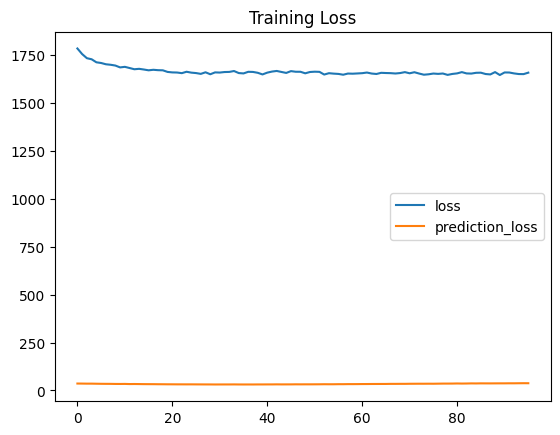

100%|██████████| 866/866 [00:49<00:00, 17.36it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 28.5714 26.4378 26.4378
Cyclist AP@0.5: 18.1818 56.4593 56.4593
Car AP@0.7: 99.5984 85.6653 83.6604
==========AOS==========
Pedestrian AOS@0.5: 5.8323 5.6502 5.6502
Cyclist AOS@0.5: 15.1259 31.3707 31.3707
Car AOS@0.7: 93.7074 86.6667 84.1486
==========BBOX_BEV==========
Pedestrian AP@0.5: 40.9091 37.0130 37.0130
Cyclist AP@0.5: 18.1818 37.6794 37.6794
Car AP@0.7: 87.0794 82.1868 71.2637
==========BBOX_3D==========
Pedestrian AP@0.5: 21.1039 19.4805 19.4805
Cyclist AP@0.5: 18.1818 20.3349 20.3349
Car AP@0.7: 72.5635 56.1833 53.6603

==========Overall==========
bbox_2d AP: 48.7839 56.1875 55.5192
AOS AP: 38.2219 41.2292 40.3898
bbox_bev AP: 48.7234 52.2931 48.6520
bbox_3d AP: 37.2831 31.9996 31.1586


100%|██████████| 866/866 [01:21<00:00, 10.60it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 655 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 26.9481 19.9443 19.9443
Cyclist AP@0.5: 18.1818 41.8660 41.8660
Car AP@0.7: 42.6806 37.2206 30.5388
==========AOS==========
Pedestrian AOS@0.5: 6.3021 5.7839 5.7839
Cyclist AOS@0.5: 0.6374 3.0829 3.0829
Car AOS@0.7: 38.7950 34.2706 32.1780
==========BBOX_BEV==========
Pedestrian AP@0.5: 29.8701 26.9944 26.9944
Cyclist AP@0.5: 18.1818 11.9617 11.9617
Car AP@0.7: 38.5385 26.2351 20.6716
==========BBOX_3D==========
Pedestrian AP@0.5: 11.0390 10.3896 10.3896
Cyclist AP@0.5: 4.5455 2.8708 2.8708
Car AP@0.7: 17.7846 11.4474 10.7384

==========Overall==========
bbox_2d AP: 29.2702 33.0103 30.7831
AOS AP: 15.2448 14.3791 13.6816
bbox_bev AP: 28.8635 21.7304 19.8759
bbox_3d AP: 11.1230 8.2360 7.9996
==================== 96 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 97 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 98 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


==================== 99 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 100 ====================


100%|██████████| 1755/1755 [19:32<00:00,  1.50it/s]


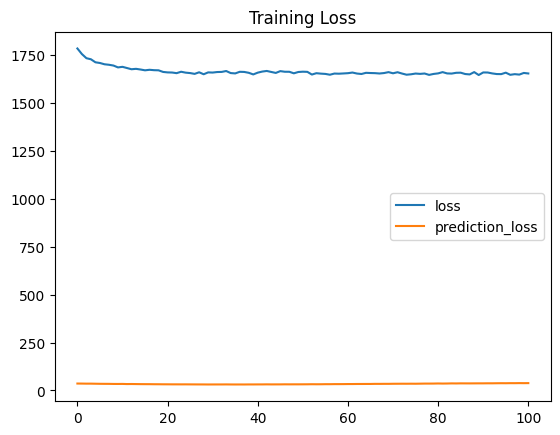

100%|██████████| 866/866 [00:50<00:00, 17.10it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 21.3745 20.8720 20.8720
Cyclist AP@0.5: 18.1818 81.3397 81.3397
Car AP@0.7: 90.1677 84.2345 82.2094
==========AOS==========
Pedestrian AOS@0.5: 5.7381 5.1655 5.1655
Cyclist AOS@0.5: 7.1309 18.7316 18.7316
Car AOS@0.7: 90.0377 87.4840 85.1890
==========BBOX_BEV==========
Pedestrian AP@0.5: 70.6169 63.8683 63.8683
Cyclist AP@0.5: 18.1818 49.7608 49.7608
Car AP@0.7: 86.9131 80.8542 69.9521
==========BBOX_3D==========
Pedestrian AP@0.5: 52.3810 41.8831 41.8831
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 70.9091 55.5470 52.6988

==========Overall==========
bbox_2d AP: 43.2413 62.1487 61.4737
AOS AP: 34.3023 37.1271 36.3620
bbox_bev AP: 58.5706 64.8277 61.1937
bbox_3d AP: 47.1573 42.0461 41.0967


100%|██████████| 866/866 [01:21<00:00, 10.62it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 651 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 11.2554 10.5751 10.5751
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 58.3614 42.3279 40.6566
==========AOS==========
Pedestrian AOS@0.5: 2.6008 2.4498 2.4498
Cyclist AOS@0.5: 0.2438 2.2159 2.2159
Car AOS@0.7: 49.4429 39.1308 39.3388
==========BBOX_BEV==========
Pedestrian AP@0.5: 39.7727 30.6122 30.6122
Cyclist AP@0.5: 13.6364 11.0048 11.0048
Car AP@0.7: 52.5133 30.4130 28.7183
==========BBOX_3D==========
Pedestrian AP@0.5: 21.3745 19.4805 19.4805
Cyclist AP@0.5: 4.5455 3.1100 3.1100
Car AP@0.7: 26.1969 13.2887 12.3596

==========Overall==========
bbox_2d AP: 29.2662 31.0315 30.4744
AOS AP: 17.4292 14.5989 14.6682
bbox_bev AP: 35.3075 24.0100 23.4451
bbox_3d AP: 17.3723 11.9598 11.6501
==================== 101 ====================


100%|██████████| 1755/1755 [19:35<00:00,  1.49it/s]


==================== 102 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 103 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 104 ====================


100%|██████████| 1755/1755 [19:32<00:00,  1.50it/s]


==================== 105 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


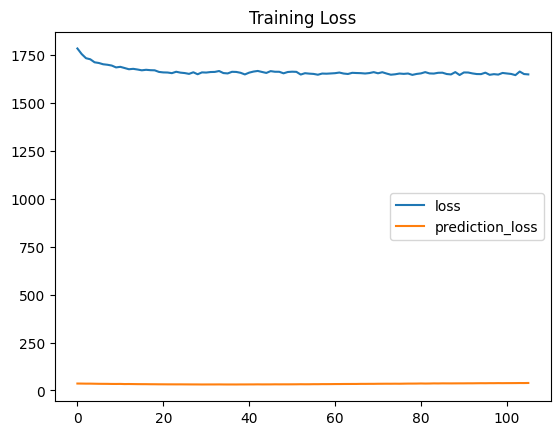

100%|██████████| 866/866 [00:50<00:00, 17.32it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 28.5714 26.4378 26.4378
Cyclist AP@0.5: 18.1818 71.0526 71.0526
Car AP@0.7: 90.2597 85.5584 83.5606
==========AOS==========
Pedestrian AOS@0.5: 7.3657 7.0531 7.0531
Cyclist AOS@0.5: 5.3864 17.3787 17.3787
Car AOS@0.7: 90.2988 87.9801 87.2929
==========BBOX_BEV==========
Pedestrian AP@0.5: 40.1515 37.0130 37.0130
Cyclist AP@0.5: 18.1818 64.5933 64.5933
Car AP@0.7: 85.8991 81.0853 70.5458
==========BBOX_3D==========
Pedestrian AP@0.5: 29.8701 27.5510 27.5510
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 70.1764 64.5688 54.7758

==========Overall==========
bbox_2d AP: 45.6710 61.0163 60.3503
AOS AP: 34.3503 37.4706 37.2416
bbox_bev AP: 48.0775 60.8972 57.3840
bbox_3d AP: 39.4094 44.1037 40.8394


100%|██████████| 866/866 [01:21<00:00, 10.58it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 656 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 13.4199 12.0594 12.0594
Cyclist AP@0.5: 18.1818 64.5933 64.5933
Car AP@0.7: 28.1525 26.2292 21.5262
==========AOS==========
Pedestrian AOS@0.5: 3.0650 2.4898 2.4898
Cyclist AOS@0.5: 0.0805 7.0452 7.0452
Car AOS@0.7: 23.3787 22.0834 21.5600
==========BBOX_BEV==========
Pedestrian AP@0.5: 20.2922 18.3210 18.3210
Cyclist AP@0.5: 13.6364 12.4402 12.4402
Car AP@0.7: 30.3750 20.8657 20.1049
==========BBOX_3D==========
Pedestrian AP@0.5: 11.4719 10.5751 10.5751
Cyclist AP@0.5: 3.4091 6.4593 6.4593
Car AP@0.7: 10.7332 7.2325 6.8492

==========Overall==========
bbox_2d AP: 19.9181 34.2939 32.7263
AOS AP: 8.8414 10.5395 10.3650
bbox_bev AP: 21.4345 17.2089 16.9554
bbox_3d AP: 8.5380 8.0890 7.9612
==================== 106 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 107 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 108 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 109 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 110 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


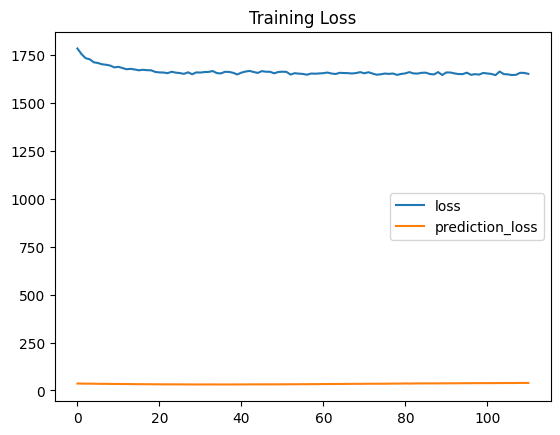

100%|██████████| 866/866 [00:49<00:00, 17.43it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 20.0216 18.3210 18.3210
Cyclist AP@0.5: 18.1818 56.4593 56.4593
Car AP@0.7: 88.5490 83.2303 80.8183
==========AOS==========
Pedestrian AOS@0.5: 15.4207 14.8505 14.8505
Cyclist AOS@0.5: 15.5343 37.5153 37.5153
Car AOS@0.7: 89.4762 85.6157 83.7629
==========BBOX_BEV==========
Pedestrian AP@0.5: 56.2771 50.4638 50.4638
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 85.8586 79.6228 69.4340
==========BBOX_3D==========
Pedestrian AP@0.5: 37.5000 29.2208 29.2208
Cyclist AP@0.5: 18.1818 21.5311 21.5311
Car AP@0.7: 65.1424 50.5463 42.1888

==========Overall==========
bbox_2d AP: 42.2508 52.6702 51.8662
AOS AP: 40.1437 45.9939 45.3762
bbox_bev AP: 53.4392 56.7593 53.3631
bbox_3d AP: 40.2747 33.7661 30.9802


100%|██████████| 866/866 [01:21<00:00, 10.68it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 650 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 12.9870 11.8738 11.8738
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 44.1518 37.5902 36.6664
==========AOS==========
Pedestrian AOS@0.5: 3.9726 3.4298 3.4298
Cyclist AOS@0.5: 1.1659 4.5979 4.5979
Car AOS@0.7: 43.4766 38.9881 39.0732
==========BBOX_BEV==========
Pedestrian AP@0.5: 37.5000 28.9425 28.9425
Cyclist AP@0.5: 13.6364 11.0048 11.0048
Car AP@0.7: 40.5890 27.1028 26.1037
==========BBOX_3D==========
Pedestrian AP@0.5: 11.2554 10.5751 10.5751
Cyclist AP@0.5: 4.5455 5.3828 5.3828
Car AP@0.7: 13.1474 10.4661 7.3442

==========Overall==========
bbox_2d AP: 25.1069 34.3508 34.0429
AOS AP: 16.2050 15.6719 15.7003
bbox_bev AP: 30.5751 22.3500 22.0170
bbox_3d AP: 9.6494 8.8080 7.7674
==================== 111 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 112 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 113 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 114 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 115 ====================


100%|██████████| 1755/1755 [19:32<00:00,  1.50it/s]


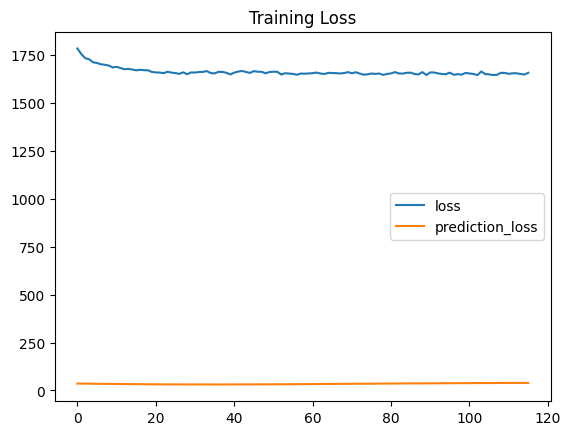

100%|██████████| 866/866 [00:49<00:00, 17.58it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 7.3052 7.0965 7.0965
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 90.1730 86.1435 83.2143
==========AOS==========
Pedestrian AOS@0.5: 1.4357 1.3952 1.3952
Cyclist AOS@0.5: 13.6350 30.0414 30.0414
Car AOS@0.7: 89.8484 87.0449 86.2211
==========BBOX_BEV==========
Pedestrian AP@0.5: 53.2468 42.2078 42.2078
Cyclist AP@0.5: 18.1818 42.7033 42.7033
Car AP@0.7: 84.9389 71.9347 68.9628
==========BBOX_3D==========
Pedestrian AP@0.5: 17.8571 12.9870 12.9870
Cyclist AP@0.5: 18.1818 19.7368 19.7368
Car AP@0.7: 66.7656 54.5558 52.0006

==========Overall==========
bbox_2d AP: 38.5533 53.6876 52.7112
AOS AP: 34.9730 39.4938 39.2192
bbox_bev AP: 52.1225 52.2820 51.2913
bbox_3d AP: 34.2682 29.0932 28.2415


100%|██████████| 866/866 [01:21<00:00, 10.62it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 652 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 12.5541 12.0594 12.0594
Cyclist AP@0.5: 13.6364 37.6794 37.6794
Car AP@0.7: 42.7227 38.6674 36.9761
==========AOS==========
Pedestrian AOS@0.5: 1.1001 0.7933 0.7933
Cyclist AOS@0.5: 0.4408 2.1821 2.1821
Car AOS@0.7: 38.9495 37.2756 35.9697
==========BBOX_BEV==========
Pedestrian AP@0.5: 19.2100 17.6252 17.6252
Cyclist AP@0.5: 13.6364 11.9617 11.9617
Car AP@0.7: 37.7782 21.4374 20.0643
==========BBOX_3D==========
Pedestrian AP@0.5: 6.6558 6.2616 6.2616
Cyclist AP@0.5: 4.5455 5.0239 5.0239
Car AP@0.7: 13.2101 10.9400 10.1774

==========Overall==========
bbox_2d AP: 22.9711 29.4687 28.9050
AOS AP: 13.4968 13.4170 12.9817
bbox_bev AP: 23.5415 17.0081 16.5504
bbox_3d AP: 8.1371 7.4085 7.1543
==================== 116 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 117 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 118 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 119 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 120 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


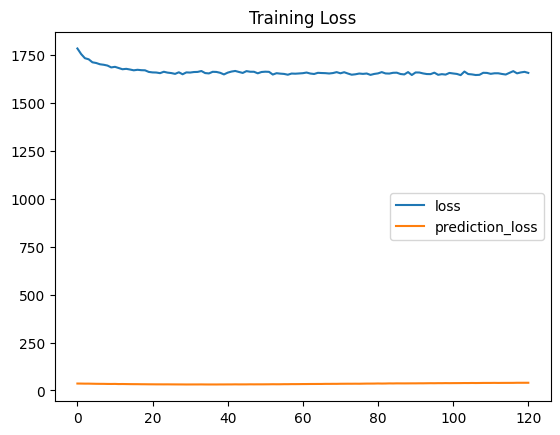

100%|██████████| 866/866 [00:50<00:00, 17.27it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 20.2922 19.9443 19.9443
Cyclist AP@0.5: 18.1818 56.4593 56.4593
Car AP@0.7: 99.3000 85.7438 83.8772
==========AOS==========
Pedestrian AOS@0.5: 4.7104 4.1493 4.1493
Cyclist AOS@0.5: 12.6483 36.6142 36.6142
Car AOS@0.7: 98.2243 88.7130 88.1634
==========BBOX_BEV==========
Pedestrian AP@0.5: 54.1126 41.8831 41.8831
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 86.9211 81.9215 71.3117
==========BBOX_3D==========
Pedestrian AP@0.5: 39.7727 29.7774 29.7774
Cyclist AP@0.5: 15.9091 28.7081 28.7081
Car AP@0.7: 67.1642 54.7623 52.7355

==========Overall==========
bbox_2d AP: 45.9247 54.0492 53.4270
AOS AP: 38.5277 43.1588 42.9756
bbox_bev AP: 53.0718 54.6653 51.1287
bbox_3d AP: 40.9487 37.7493 37.0737


100%|██████████| 866/866 [01:21<00:00, 10.64it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 656 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 10.6061 7.5139 7.5139
Cyclist AP@0.5: 18.1818 54.5455 54.5455
Car AP@0.7: 51.5031 38.8388 37.5843
==========AOS==========
Pedestrian AOS@0.5: 6.2031 5.6920 5.6920
Cyclist AOS@0.5: 0.4354 3.6717 3.6717
Car AOS@0.7: 43.2141 38.4570 36.6537
==========BBOX_BEV==========
Pedestrian AP@0.5: 29.5455 26.1596 26.1596
Cyclist AP@0.5: 13.6364 12.4402 12.4402
Car AP@0.7: 38.7132 26.4688 20.9614
==========BBOX_3D==========
Pedestrian AP@0.5: 6.3312 5.8442 5.8442
Cyclist AP@0.5: 3.4091 6.1005 6.1005
Car AP@0.7: 13.4921 11.1317 10.5495

==========Overall==========
bbox_2d AP: 26.7637 33.6327 33.2146
AOS AP: 16.6175 15.9402 15.3391
bbox_bev AP: 27.2983 21.6895 19.8537
bbox_3d AP: 7.7441 7.6921 7.4980
==================== 121 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 122 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 123 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 124 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 125 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


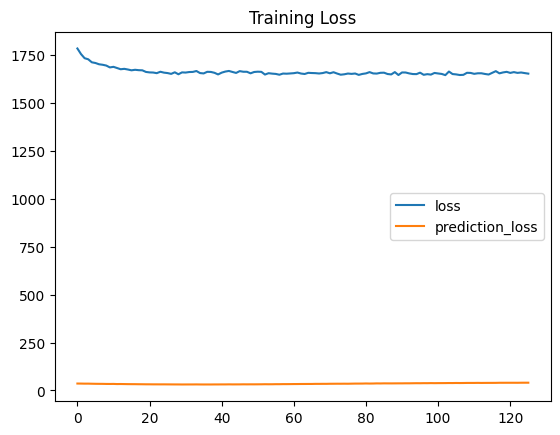

100%|██████████| 866/866 [00:49<00:00, 17.33it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 17.8571 12.9870 12.9870
Cyclist AP@0.5: 18.1818 69.9761 69.9761
Car AP@0.7: 99.6020 85.9965 83.9586
==========AOS==========
Pedestrian AOS@0.5: 2.0787 2.1223 2.1223
Cyclist AOS@0.5: 6.1507 38.8611 38.8611
Car AOS@0.7: 99.1750 87.1357 86.6977
==========BBOX_BEV==========
Pedestrian AP@0.5: 18.9394 17.8571 17.8571
Cyclist AP@0.5: 18.1818 56.4593 56.4593
Car AP@0.7: 87.2077 82.2017 71.4042
==========BBOX_3D==========
Pedestrian AP@0.5: 12.9870 12.2449 12.2449
Cyclist AP@0.5: 18.1818 42.7033 42.7033
Car AP@0.7: 81.0981 64.3122 54.6189

==========Overall==========
bbox_2d AP: 45.2137 56.3199 55.6406
AOS AP: 35.8014 42.7063 42.5604
bbox_bev AP: 41.4430 52.1727 48.5736
bbox_3d AP: 37.4223 39.7535 36.5224


100%|██████████| 866/866 [01:21<00:00, 10.65it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 653 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 18.1277 13.1725 13.1725
Cyclist AP@0.5: 11.3636 50.7177 50.7177
Car AP@0.7: 42.5296 37.4820 37.0838
==========AOS==========
Pedestrian AOS@0.5: 3.6037 3.5030 3.5030
Cyclist AOS@0.5: 2.2843 16.2054 16.2054
Car AOS@0.7: 36.5216 32.0237 32.3042
==========BBOX_BEV==========
Pedestrian AP@0.5: 19.7511 17.8571 17.8571
Cyclist AP@0.5: 2.2727 7.1770 7.1770
Car AP@0.7: 42.6338 28.1395 26.9697
==========BBOX_3D==========
Pedestrian AP@0.5: 10.8225 7.3748 7.3748
Cyclist AP@0.5: 2.2727 6.4593 6.4593
Car AP@0.7: 19.1670 12.0800 11.4485

==========Overall==========
bbox_2d AP: 24.0070 33.7907 33.6580
AOS AP: 14.1365 17.2441 17.3376
bbox_bev AP: 21.5526 17.7246 17.3346
bbox_3d AP: 10.7541 8.6380 8.4275
==================== 126 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 127 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


==================== 128 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 129 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.51it/s]


==================== 130 ====================


100%|██████████| 1755/1755 [19:31<00:00,  1.50it/s]


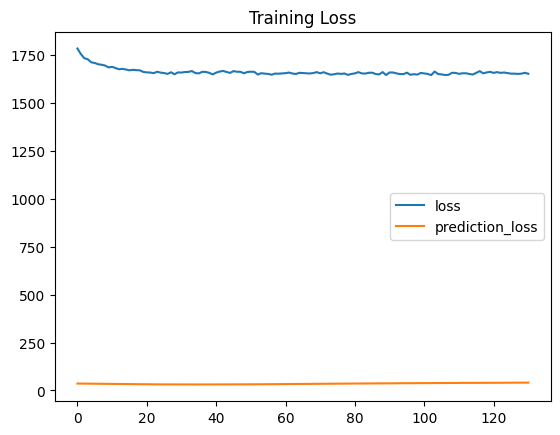

100%|██████████| 866/866 [00:50<00:00, 17.04it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 11.4719 10.2041 10.2041
Cyclist AP@0.5: 18.1818 64.5933 64.5933
Car AP@0.7: 90.7258 86.2444 84.5012
==========AOS==========
Pedestrian AOS@0.5: 2.2447 2.2898 2.2898
Cyclist AOS@0.5: 14.0453 18.9340 18.9340
Car AOS@0.7: 90.3608 88.4998 87.9321
==========BBOX_BEV==========
Pedestrian AP@0.5: 42.8030 37.6623 37.6623
Cyclist AP@0.5: 18.1818 42.7033 42.7033
Car AP@0.7: 86.6321 81.4707 70.8178
==========BBOX_3D==========
Pedestrian AP@0.5: 28.2468 20.4082 20.4082
Cyclist AP@0.5: 18.1818 27.2727 27.2727
Car AP@0.7: 72.1829 64.8581 55.3376

==========Overall==========
bbox_2d AP: 40.1265 53.6806 53.0995
AOS AP: 35.5502 36.5745 36.3853
bbox_bev AP: 49.2056 53.9455 50.3945
bbox_3d AP: 39.5372 37.5130 34.3395


100%|██████████| 866/866 [01:21<00:00, 10.64it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 652 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 6.4935 5.8442 5.8442
Cyclist AP@0.5: 18.1818 50.7177 50.7177
Car AP@0.7: 50.5111 39.3836 37.8466
==========AOS==========
Pedestrian AOS@0.5: 0.4777 0.3961 0.3961
Cyclist AOS@0.5: 0.3182 1.1243 1.1243
Car AOS@0.7: 38.8139 34.6916 32.8414
==========BBOX_BEV==========
Pedestrian AP@0.5: 13.6364 12.0594 12.0594
Cyclist AP@0.5: 15.9091 12.9187 12.9187
Car AP@0.7: 31.3771 21.4496 20.2582
==========BBOX_3D==========
Pedestrian AP@0.5: 6.9805 6.1224 6.1224
Cyclist AP@0.5: 4.5455 5.0239 5.0239
Car AP@0.7: 18.4239 12.0524 11.2397

==========Overall==========
bbox_2d AP: 25.0621 31.9818 31.4695
AOS AP: 13.2033 12.0707 11.4539
bbox_bev AP: 20.3075 15.4759 15.0787
bbox_3d AP: 9.9833 7.7329 7.4620
==================== 131 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 132 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 133 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 134 ====================


100%|██████████| 1755/1755 [19:21<00:00,  1.51it/s]


==================== 135 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


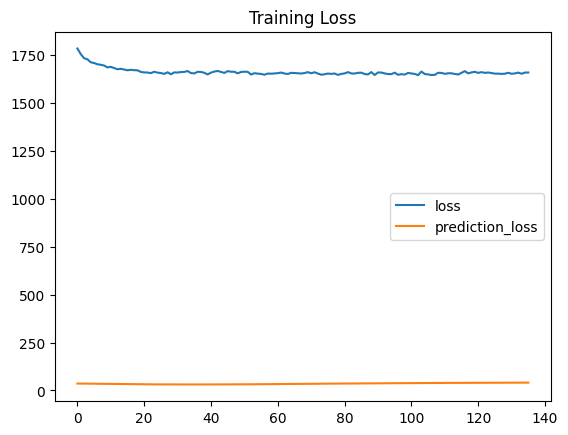

100%|██████████| 866/866 [00:49<00:00, 17.60it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 12.9870 12.0594 12.0594
Cyclist AP@0.5: 18.1818 55.5024 55.5024
Car AP@0.7: 89.8214 81.6210 71.5598
==========AOS==========
Pedestrian AOS@0.5: 11.9459 11.8312 11.8312
Cyclist AOS@0.5: 10.6043 27.3023 27.3023
Car AOS@0.7: 88.3548 80.3121 75.8235
==========BBOX_BEV==========
Pedestrian AP@0.5: 37.5000 29.4991 29.4991
Cyclist AP@0.5: 18.1818 42.7033 42.7033
Car AP@0.7: 87.4786 82.4983 71.3052
==========BBOX_3D==========
Pedestrian AP@0.5: 19.7511 17.8571 17.8571
Cyclist AP@0.5: 18.1818 30.1435 30.1435
Car AP@0.7: 53.3573 41.6265 39.3817

==========Overall==========
bbox_2d AP: 40.3301 49.7276 46.3738
AOS AP: 36.9683 39.8152 38.3190
bbox_bev AP: 47.7201 51.5669 47.8359
bbox_3d AP: 30.4301 29.8757 29.1274


100%|██████████| 866/866 [01:21<00:00, 10.66it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 649 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 17.3160 12.2449 12.2449
Cyclist AP@0.5: 13.6364 30.1435 30.1435
Car AP@0.7: 38.1441 27.5670 27.1487
==========AOS==========
Pedestrian AOS@0.5: 7.5133 6.1632 6.1632
Cyclist AOS@0.5: 1.8982 6.5527 6.5527
Car AOS@0.7: 27.2885 18.4932 18.3081
==========BBOX_BEV==========
Pedestrian AP@0.5: 20.5628 18.7848 18.7848
Cyclist AP@0.5: 13.6364 11.0048 11.0048
Car AP@0.7: 37.0111 21.3600 20.4775
==========BBOX_3D==========
Pedestrian AP@0.5: 11.0390 7.5139 7.5139
Cyclist AP@0.5: 4.5455 5.3828 5.3828
Car AP@0.7: 11.2605 6.7292 6.3329

==========Overall==========
bbox_2d AP: 23.0321 23.3185 23.1790
AOS AP: 12.2334 10.4031 10.3414
bbox_bev AP: 23.7367 17.0499 16.7557
bbox_3d AP: 8.9483 6.5420 6.4099
==================== 136 ====================


100%|██████████| 1755/1755 [19:23<00:00,  1.51it/s]


==================== 137 ====================


100%|██████████| 1755/1755 [19:22<00:00,  1.51it/s]


==================== 138 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 139 ====================


100%|██████████| 1755/1755 [19:21<00:00,  1.51it/s]


==================== 140 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


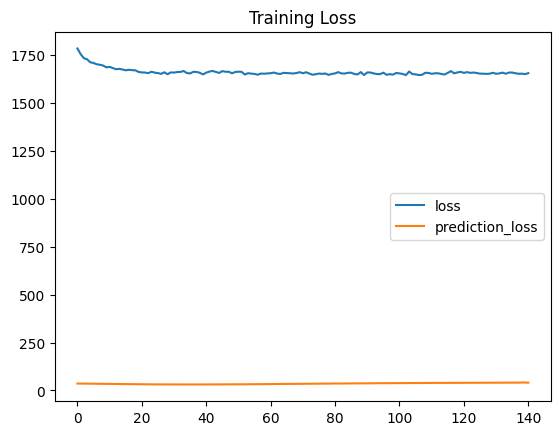

100%|██████████| 866/866 [00:50<00:00, 17.20it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 37.1212 29.4991 29.4991
Cyclist AP@0.5: 18.1818 64.5933 64.5933
Car AP@0.7: 90.4457 83.5269 81.2623
==========AOS==========
Pedestrian AOS@0.5: 15.5072 14.6006 14.6006
Cyclist AOS@0.5: 11.2198 22.1300 22.1300
Car AOS@0.7: 90.0949 86.2448 84.3350
==========BBOX_BEV==========
Pedestrian AP@0.5: 50.2165 39.2857 39.2857
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 85.6045 80.0496 69.2722
==========BBOX_3D==========
Pedestrian AP@0.5: 31.4935 28.1076 28.1076
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 68.9680 52.7386 50.6408

==========Overall==========
bbox_2d AP: 48.5829 59.2064 58.4516
AOS AP: 38.9407 40.9918 40.3552
bbox_bev AP: 51.3343 53.1756 49.5831
bbox_3d AP: 39.5478 36.5181 35.8189


100%|██████████| 866/866 [01:22<00:00, 10.52it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 648 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 17.5866 12.6160 12.6160
Cyclist AP@0.5: 15.9091 51.6746 51.6746
Car AP@0.7: 42.5101 36.8383 30.5234
==========AOS==========
Pedestrian AOS@0.5: 3.2772 2.2239 2.2239
Cyclist AOS@0.5: 0.7864 1.5856 1.5856
Car AOS@0.7: 33.6764 30.6494 28.8944
==========BBOX_BEV==========
Pedestrian AP@0.5: 19.2100 17.1614 17.1614
Cyclist AP@0.5: 15.9091 10.5263 10.5263
Car AP@0.7: 52.7073 30.4476 28.4992
==========BBOX_3D==========
Pedestrian AP@0.5: 11.0390 7.3748 7.3748
Cyclist AP@0.5: 3.4091 5.0239 5.0239
Car AP@0.7: 17.3995 11.0224 10.4158

==========Overall==========
bbox_2d AP: 25.3353 33.7096 31.6047
AOS AP: 12.5800 11.4863 10.9013
bbox_bev AP: 29.2754 19.3784 18.7290
bbox_3d AP: 10.6159 7.8070 7.6048
==================== 141 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 142 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 143 ====================


100%|██████████| 1755/1755 [19:23<00:00,  1.51it/s]


==================== 144 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 145 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


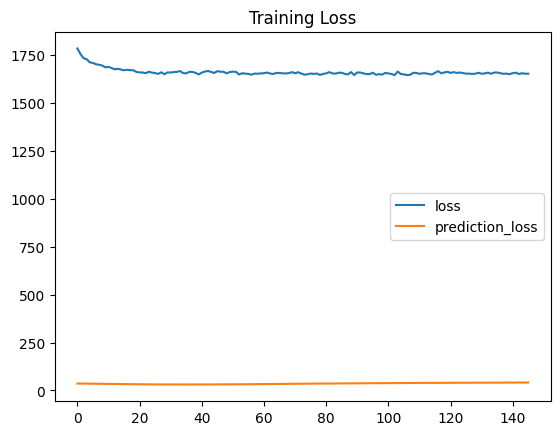

100%|██████████| 866/866 [00:49<00:00, 17.33it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 18.3983 17.6252 17.6252
Cyclist AP@0.5: 18.1818 51.6746 51.6746
Car AP@0.7: 99.7003 84.1980 81.9514
==========AOS==========
Pedestrian AOS@0.5: 2.7109 2.6928 2.6928
Cyclist AOS@0.5: 2.3501 14.5718 14.5718
Car AOS@0.7: 97.6234 85.8430 83.4048
==========BBOX_BEV==========
Pedestrian AP@0.5: 30.1948 27.8293 27.8293
Cyclist AP@0.5: 18.1818 38.5167 38.5167
Car AP@0.7: 87.4649 81.4815 70.9119
==========BBOX_3D==========
Pedestrian AP@0.5: 11.4719 10.9462 10.9462
Cyclist AP@0.5: 18.1818 26.5550 26.5550
Car AP@0.7: 80.5066 55.8965 53.7102

==========Overall==========
bbox_2d AP: 45.4268 51.1660 50.4171
AOS AP: 34.2281 34.3692 33.5565
bbox_bev AP: 45.2805 49.2758 45.7526
bbox_3d AP: 36.7201 31.1326 30.4038


100%|██████████| 866/866 [01:24<00:00, 10.30it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 649 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 3.1385 2.8757 2.8757
Cyclist AP@0.5: 18.1818 38.5167 38.5167
Car AP@0.7: 54.1663 38.8889 37.0195
==========AOS==========
Pedestrian AOS@0.5: 0.2859 0.2939 0.2939
Cyclist AOS@0.5: 0.3248 1.6641 1.6641
Car AOS@0.7: 49.3482 38.0710 36.0255
==========BBOX_BEV==========
Pedestrian AP@0.5: 6.3312 5.8442 5.8442
Cyclist AP@0.5: 15.9091 11.4833 11.4833
Car AP@0.7: 39.4331 26.4219 20.6737
==========BBOX_3D==========
Pedestrian AP@0.5: 1.9481 1.9481 1.9481
Cyclist AP@0.5: 13.6364 5.7416 5.7416
Car AP@0.7: 13.6949 10.7813 10.0725

==========Overall==========
bbox_2d AP: 25.1622 26.7604 26.1373
AOS AP: 16.6530 13.3430 12.6612
bbox_bev AP: 20.5578 14.5831 12.6670
bbox_3d AP: 9.7598 6.1570 5.9207
==================== 146 ====================


100%|██████████| 1755/1755 [19:35<00:00,  1.49it/s]


==================== 147 ====================


100%|██████████| 1755/1755 [19:38<00:00,  1.49it/s]


==================== 148 ====================


100%|██████████| 1755/1755 [19:41<00:00,  1.49it/s]


==================== 149 ====================


100%|██████████| 1755/1755 [19:33<00:00,  1.50it/s]


==================== 150 ====================


100%|██████████| 1755/1755 [19:40<00:00,  1.49it/s]


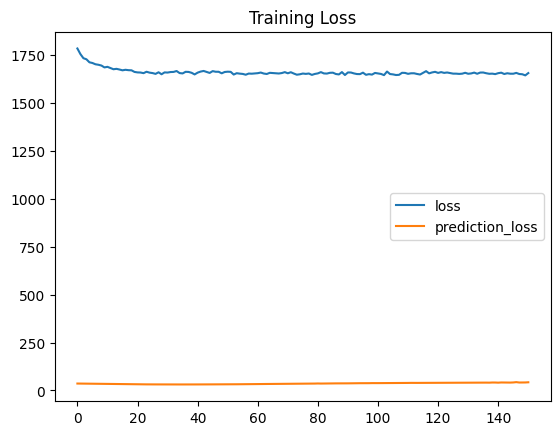

100%|██████████| 866/866 [00:50<00:00, 17.31it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 28.8961 27.2727 27.2727
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 99.4042 85.4339 83.6474
==========AOS==========
Pedestrian AOS@0.5: 12.4145 12.2110 12.2110
Cyclist AOS@0.5: 11.3547 36.1343 36.1343
Car AOS@0.7: 98.6170 88.7421 88.3035
==========BBOX_BEV==========
Pedestrian AP@0.5: 49.3506 39.6104 39.6104
Cyclist AP@0.5: 18.1818 41.0287 41.0287
Car AP@0.7: 87.2187 81.9113 71.1768
==========BBOX_3D==========
Pedestrian AP@0.5: 29.5455 26.7161 26.7161
Cyclist AP@0.5: 15.9091 27.9904 27.9904
Car AP@0.7: 70.6612 56.2903 53.9850

==========Overall==========
bbox_2d AP: 48.8274 55.4317 54.8362
AOS AP: 40.7954 45.6958 45.5496
bbox_bev AP: 51.5837 54.1835 50.6053
bbox_3d AP: 38.7052 36.9990 36.2305


100%|██████████| 866/866 [01:24<00:00, 10.21it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 650 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 28.5714 21.1039 21.1039
Cyclist AP@0.5: 3.4091 50.7177 50.7177
Car AP@0.7: 53.9148 40.7287 39.4597
==========AOS==========
Pedestrian AOS@0.5: 8.0901 7.6396 7.6396
Cyclist AOS@0.5: 1.1342 2.2148 2.2148
Car AOS@0.7: 43.6526 37.8894 37.6109
==========BBOX_BEV==========
Pedestrian AP@0.5: 17.5866 12.6160 12.6160
Cyclist AP@0.5: 4.5455 13.3971 13.3971
Car AP@0.7: 50.2113 29.1755 27.4792
==========BBOX_3D==========
Pedestrian AP@0.5: 7.1429 6.4007 6.4007
Cyclist AP@0.5: 2.2727 5.7416 5.7416
Car AP@0.7: 18.9170 12.0113 11.3510

==========Overall==========
bbox_2d AP: 28.6318 37.5168 37.0938
AOS AP: 17.6256 15.9146 15.8217
bbox_bev AP: 24.1144 18.3962 17.8308
bbox_3d AP: 9.4442 8.0512 7.8311
==================== 151 ====================


100%|██████████| 1755/1755 [19:40<00:00,  1.49it/s]


==================== 152 ====================


100%|██████████| 1755/1755 [19:37<00:00,  1.49it/s]


==================== 153 ====================


100%|██████████| 1755/1755 [19:36<00:00,  1.49it/s]


==================== 154 ====================


100%|██████████| 1755/1755 [19:42<00:00,  1.48it/s]


==================== 155 ====================


100%|██████████| 1755/1755 [19:41<00:00,  1.49it/s]


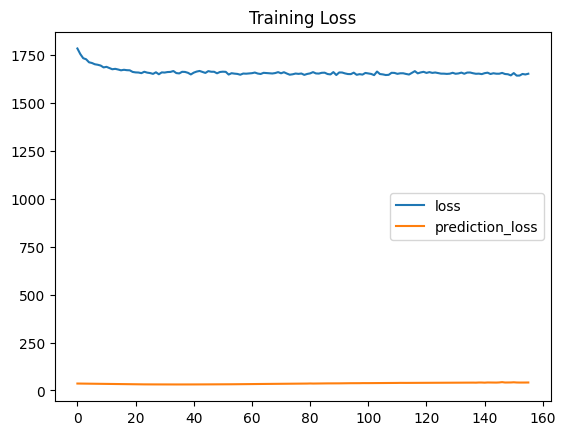

100%|██████████| 866/866 [00:50<00:00, 17.26it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 26.6234 20.4082 20.4082
Cyclist AP@0.5: 18.1818 64.5933 64.5933
Car AP@0.7: 99.6044 85.2693 83.0380
==========AOS==========
Pedestrian AOS@0.5: 14.8891 13.6279 13.6279
Cyclist AOS@0.5: 18.1504 45.8289 45.8289
Car AOS@0.7: 98.9331 88.2028 87.6237
==========BBOX_BEV==========
Pedestrian AP@0.5: 71.5909 64.7032 64.7032
Cyclist AP@0.5: 18.1818 39.3541 39.3541
Car AP@0.7: 86.5929 80.9578 70.9063
==========BBOX_3D==========
Pedestrian AP@0.5: 40.9091 31.4471 31.4471
Cyclist AP@0.5: 18.1818 21.5311 21.5311
Car AP@0.7: 80.3989 55.9917 53.8285

==========Overall==========
bbox_2d AP: 48.1365 56.7569 56.0131
AOS AP: 43.9909 49.2199 49.0268
bbox_bev AP: 58.7886 61.6717 58.3212
bbox_3d AP: 46.4966 36.3233 35.6022


100%|██████████| 866/866 [01:25<00:00, 10.09it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 651 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 10.1732 7.2356 7.2356
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 40.3240 30.5828 29.7194
==========AOS==========
Pedestrian AOS@0.5: 1.7156 1.6238 1.6238
Cyclist AOS@0.5: 0.5609 2.5868 2.5868
Car AOS@0.7: 33.9079 28.6122 28.4546
==========BBOX_BEV==========
Pedestrian AP@0.5: 37.1212 28.9425 28.9425
Cyclist AP@0.5: 15.9091 11.9617 11.9617
Car AP@0.7: 30.9306 20.4055 19.4674
==========BBOX_3D==========
Pedestrian AP@0.5: 5.8442 5.7050 5.7050
Cyclist AP@0.5: 11.3636 5.0239 5.0239
Car AP@0.7: 13.4122 10.6782 10.0541

==========Overall==========
bbox_2d AP: 22.8930 30.4690 30.1812
AOS AP: 12.0614 10.9409 10.8884
bbox_bev AP: 27.9870 20.4366 20.1239
bbox_3d AP: 10.2067 7.1357 6.9277
==================== 156 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


==================== 157 ====================


100%|██████████| 1755/1755 [19:38<00:00,  1.49it/s]


==================== 158 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 159 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 160 ====================


100%|██████████| 1755/1755 [19:30<00:00,  1.50it/s]


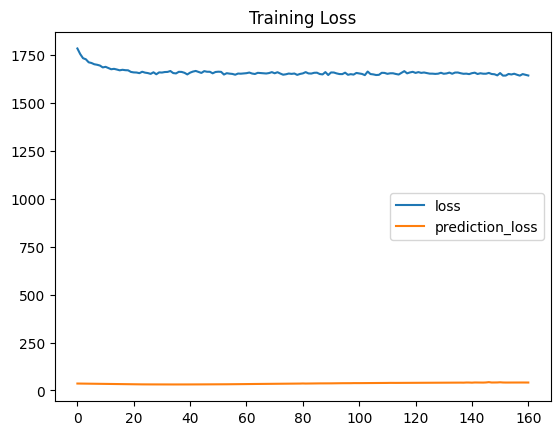

100%|██████████| 866/866 [00:51<00:00, 16.97it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 17.3160 13.1725 13.1725
Cyclist AP@0.5: 18.1818 81.3397 81.3397
Car AP@0.7: 88.7338 82.1249 80.5102
==========AOS==========
Pedestrian AOS@0.5: 5.3112 3.5809 3.5809
Cyclist AOS@0.5: 4.9591 42.9453 42.9453
Car AOS@0.7: 88.9394 84.3163 84.4067
==========BBOX_BEV==========
Pedestrian AP@0.5: 66.2338 52.3191 52.3191
Cyclist AP@0.5: 18.1818 51.6746 51.6746
Car AP@0.7: 87.5722 82.3896 71.7988
==========BBOX_3D==========
Pedestrian AP@0.5: 41.6667 31.4471 31.4471
Cyclist AP@0.5: 15.9091 28.7081 28.7081
Car AP@0.7: 66.6188 52.3802 50.5737

==========Overall==========
bbox_2d AP: 41.4105 58.8790 58.3408
AOS AP: 33.0699 43.6142 43.6443
bbox_bev AP: 57.3292 62.1278 58.5975
bbox_3d AP: 41.3982 37.5118 36.9096


100%|██████████| 866/866 [01:21<00:00, 10.66it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 648 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 17.5866 12.8015 12.8015
Cyclist AP@0.5: 15.9091 55.5024 55.5024
Car AP@0.7: 19.7374 18.0215 17.6295
==========AOS==========
Pedestrian AOS@0.5: 2.7594 2.2684 2.2684
Cyclist AOS@0.5: 1.8499 15.7476 15.7476
Car AOS@0.7: 17.9124 16.0287 16.3189
==========BBOX_BEV==========
Pedestrian AP@0.5: 28.5714 21.1039 21.1039
Cyclist AP@0.5: 13.6364 7.5359 7.5359
Car AP@0.7: 41.9222 27.8609 26.1983
==========BBOX_3D==========
Pedestrian AP@0.5: 18.6688 13.3581 13.3581
Cyclist AP@0.5: 1.1364 2.6316 2.6316
Car AP@0.7: 7.1473 6.0486 5.6858

==========Overall==========
bbox_2d AP: 17.7444 28.7751 28.6444
AOS AP: 7.5072 11.3483 11.4450
bbox_bev AP: 28.0433 18.8336 18.2794
bbox_3d AP: 8.9842 7.3461 7.2252
==================== 161 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 162 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


==================== 163 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 164 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


==================== 165 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


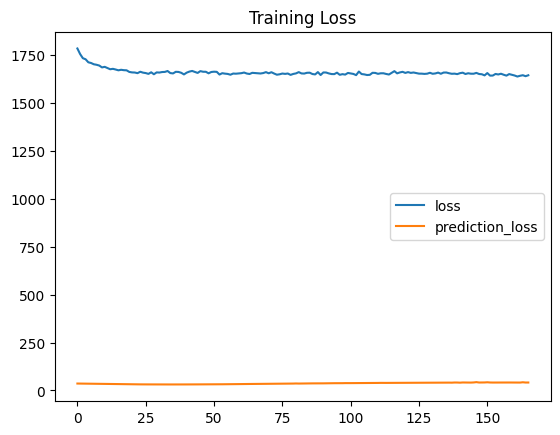

100%|██████████| 866/866 [00:49<00:00, 17.64it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 20.8333 19.7124 19.7124
Cyclist AP@0.5: 18.1818 52.6316 52.6316
Car AP@0.7: 90.7232 85.4763 83.5443
==========AOS==========
Pedestrian AOS@0.5: 12.1344 11.1576 11.1576
Cyclist AOS@0.5: 13.6237 36.5483 36.5483
Car AOS@0.7: 90.3634 87.8028 87.0386
==========BBOX_BEV==========
Pedestrian AP@0.5: 39.7727 31.4471 31.4471
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 86.2447 81.2059 70.9783
==========BBOX_3D==========
Pedestrian AP@0.5: 18.9394 17.8571 17.8571
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 71.5194 63.7502 54.4994

==========Overall==========
bbox_2d AP: 43.2461 52.6068 51.9628
AOS AP: 38.7072 45.1695 44.9148
bbox_bev AP: 48.0664 50.9481 47.5389
bbox_3d AP: 36.2135 36.7718 33.6882


100%|██████████| 866/866 [01:22<00:00, 10.53it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 649 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 11.6883 10.9462 10.9462
Cyclist AP@0.5: 18.1818 52.6316 52.6316
Car AP@0.7: 42.0800 30.7573 29.8498
==========AOS==========
Pedestrian AOS@0.5: 1.6160 1.2998 1.2998
Cyclist AOS@0.5: 0.4192 2.0186 2.0186
Car AOS@0.7: 34.7634 28.7559 29.2760
==========BBOX_BEV==========
Pedestrian AP@0.5: 18.6688 17.3933 17.3933
Cyclist AP@0.5: 18.1818 13.3971 13.3971
Car AP@0.7: 40.9364 27.8306 26.3076
==========BBOX_3D==========
Pedestrian AP@0.5: 6.1688 5.8442 5.8442
Cyclist AP@0.5: 11.3636 6.4593 6.4593
Car AP@0.7: 18.2905 11.7774 10.9954

==========Overall==========
bbox_2d AP: 23.9834 31.4450 31.1425
AOS AP: 12.2662 10.6914 10.8648
bbox_bev AP: 25.9290 19.5403 19.0327
bbox_3d AP: 11.9410 8.0270 7.7663
==================== 166 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 167 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 168 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 169 ====================


100%|██████████| 1755/1755 [19:28<00:00,  1.50it/s]


==================== 170 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


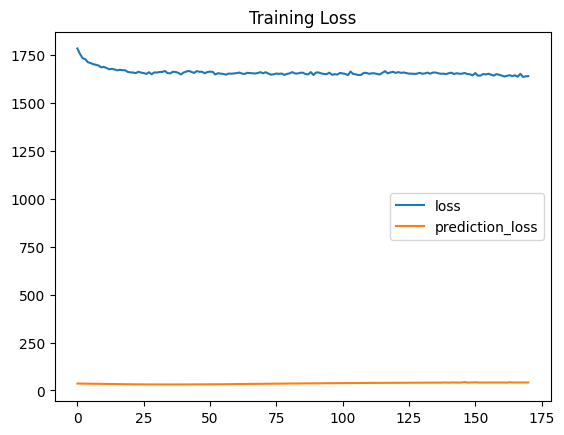

100%|██████████| 866/866 [00:50<00:00, 17.10it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 20.8333 19.7124 19.7124
Cyclist AP@0.5: 18.1818 49.7608 49.7608
Car AP@0.7: 99.7015 86.4051 83.9090
==========AOS==========
Pedestrian AOS@0.5: 5.3235 5.1008 5.1008
Cyclist AOS@0.5: 4.5373 30.0730 30.0730
Car AOS@0.7: 98.3185 87.9881 87.3018
==========BBOX_BEV==========
Pedestrian AP@0.5: 56.2771 50.0928 50.0928
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 86.3004 81.3206 70.7404
==========BBOX_3D==========
Pedestrian AP@0.5: 51.0823 39.6104 39.6104
Cyclist AP@0.5: 15.9091 27.2727 27.2727
Car AP@0.7: 71.6821 64.1428 54.0764

==========Overall==========
bbox_2d AP: 46.2389 51.9594 51.1274
AOS AP: 36.0598 41.0540 40.8252
bbox_bev AP: 53.5864 57.2016 53.6748
bbox_3d AP: 46.2245 43.6753 40.3198


100%|██████████| 866/866 [01:22<00:00, 10.55it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 652 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 12.1212 11.1317 11.1317
Cyclist AP@0.5: 18.1818 81.2121 81.2121
Car AP@0.7: 55.0485 40.2656 38.3685
==========AOS==========
Pedestrian AOS@0.5: 1.5391 1.2259 1.2259
Cyclist AOS@0.5: 0.0988 2.5714 2.5714
Car AOS@0.7: 40.4169 30.6954 28.7281
==========BBOX_BEV==========
Pedestrian AP@0.5: 18.3983 13.1725 13.1725
Cyclist AP@0.5: 13.6364 13.3971 13.3971
Car AP@0.7: 41.2061 27.7371 26.3085
==========BBOX_3D==========
Pedestrian AP@0.5: 11.6883 10.3896 10.3896
Cyclist AP@0.5: 4.5455 6.1005 6.1005
Car AP@0.7: 18.0382 11.3585 10.7330

==========Overall==========
bbox_2d AP: 28.4505 44.2032 43.5708
AOS AP: 14.0182 11.4976 10.8418
bbox_bev AP: 24.4136 18.1022 17.6261
bbox_3d AP: 11.4240 9.2829 9.0743
==================== 171 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 172 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 173 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 174 ====================


100%|██████████| 1755/1755 [19:29<00:00,  1.50it/s]


==================== 175 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


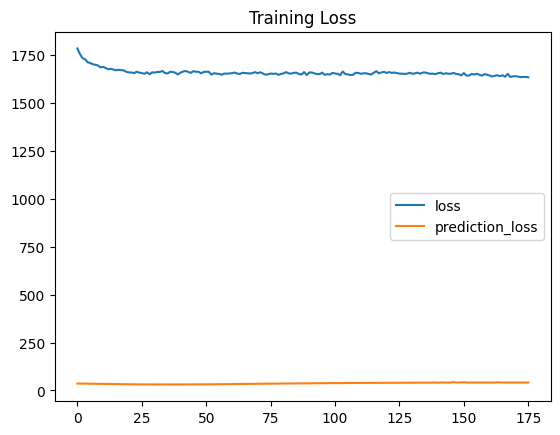

100%|██████████| 866/866 [00:50<00:00, 17.17it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 51.5152 40.9091 40.9091
Cyclist AP@0.5: 18.1818 81.3397 81.3397
Car AP@0.7: 90.2571 86.5900 84.7497
==========AOS==========
Pedestrian AOS@0.5: 8.0806 7.2083 7.2083
Cyclist AOS@0.5: 3.0398 20.1604 20.1604
Car AOS@0.7: 89.9530 88.9292 88.5284
==========BBOX_BEV==========
Pedestrian AP@0.5: 31.4935 28.9425 28.9425
Cyclist AP@0.5: 18.1818 54.5455 54.5455
Car AP@0.7: 87.5319 82.6825 71.9034
==========BBOX_3D==========
Pedestrian AP@0.5: 21.6450 19.7124 19.7124
Cyclist AP@0.5: 4.5455 21.5311 21.5311
Car AP@0.7: 82.2727 66.4336 56.4715

==========Overall==========
bbox_2d AP: 53.3180 69.6129 68.9995
AOS AP: 33.6911 38.7660 38.6324
bbox_bev AP: 45.7358 55.3901 51.7971
bbox_3d AP: 36.1544 35.8924 32.5717


100%|██████████| 866/866 [01:21<00:00, 10.56it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 655 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 20.5628 18.3210 18.3210
Cyclist AP@0.5: 11.3636 66.7464 66.7464
Car AP@0.7: 54.3595 39.9315 38.7310
==========AOS==========
Pedestrian AOS@0.5: 3.3645 2.9481 2.9481
Cyclist AOS@0.5: 0.3295 6.2105 6.2105
Car AOS@0.7: 48.2077 40.5982 39.9794
==========BBOX_BEV==========
Pedestrian AP@0.5: 6.9805 6.2616 6.2616
Cyclist AP@0.5: 11.3636 13.3971 13.3971
Car AP@0.7: 42.5516 28.4666 26.9003
==========BBOX_3D==========
Pedestrian AP@0.5: 5.0325 3.0612 3.0612
Cyclist AP@0.5: 2.2727 5.3828 5.3828
Car AP@0.7: 20.2221 12.7190 11.8521

==========Overall==========
bbox_2d AP: 28.7620 41.6663 41.2661
AOS AP: 17.3006 16.5856 16.3794
bbox_bev AP: 20.2986 16.0418 15.5197
bbox_3d AP: 9.1758 7.0543 6.7654
==================== 176 ====================


100%|██████████| 1755/1755 [19:27<00:00,  1.50it/s]


==================== 177 ====================


100%|██████████| 1755/1755 [19:26<00:00,  1.50it/s]


==================== 178 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


==================== 179 ====================


100%|██████████| 1755/1755 [19:23<00:00,  1.51it/s]


==================== 180 ====================


100%|██████████| 1755/1755 [19:23<00:00,  1.51it/s]


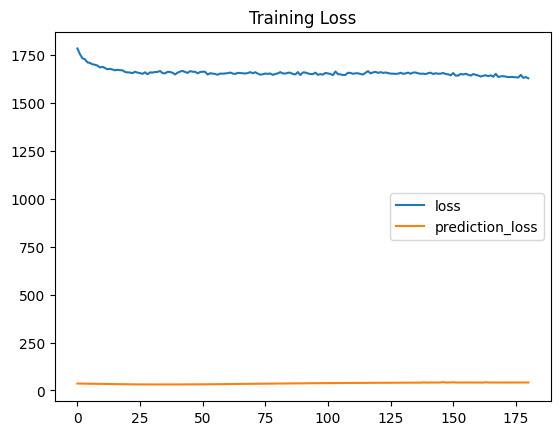

100%|██████████| 866/866 [00:51<00:00, 16.96it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 56.9551 53.0612 53.0612
Cyclist AP@0.5: 18.1818 65.6699 65.6699
Car AP@0.7: 99.1018 84.4082 82.0478
==========AOS==========
Pedestrian AOS@0.5: 20.9706 18.8257 18.8257
Cyclist AOS@0.5: 4.5470 51.3359 51.3359
Car AOS@0.7: 97.9858 87.0326 85.5436
==========BBOX_BEV==========
Pedestrian AP@0.5: 83.2421 67.6252 67.6252
Cyclist AP@0.5: 18.1818 42.7033 42.7033
Car AP@0.7: 87.2944 81.3696 70.8320
==========BBOX_3D==========
Pedestrian AP@0.5: 69.4962 55.6586 55.6586
Cyclist AP@0.5: 18.1818 19.1388 19.1388
Car AP@0.7: 81.2590 63.7291 53.9767

==========Overall==========
bbox_2d AP: 58.0796 67.7131 66.9263
AOS AP: 41.1678 52.3981 51.9017
bbox_bev AP: 62.9061 63.8994 60.3869
bbox_3d AP: 56.3123 46.1755 42.9247


100%|██████████| 866/866 [01:21<00:00, 10.61it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 656 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 40.3919 31.4471 31.4471
Cyclist AP@0.5: 13.6364 30.8612 30.8612
Car AP@0.7: 29.6783 26.7161 21.1785
==========AOS==========
Pedestrian AOS@0.5: 7.2892 6.6067 6.6067
Cyclist AOS@0.5: 1.5810 26.4485 26.4485
Car AOS@0.7: 30.3017 27.6150 26.7553
==========BBOX_BEV==========
Pedestrian AP@0.5: 37.7246 29.2208 29.2208
Cyclist AP@0.5: 11.3636 7.1770 7.1770
Car AP@0.7: 41.1431 27.6129 21.5806
==========BBOX_3D==========
Pedestrian AP@0.5: 26.4562 19.9443 19.9443
Cyclist AP@0.5: 3.4091 2.6316 2.6316
Car AP@0.7: 12.5874 10.4102 7.1966

==========Overall==========
bbox_2d AP: 27.9022 29.6748 27.8289
AOS AP: 13.0573 20.2234 19.9368
bbox_bev AP: 30.0771 21.3369 19.3261
bbox_3d AP: 14.1509 10.9954 9.9242
==================== 181 ====================


100%|██████████| 1755/1755 [19:21<00:00,  1.51it/s]


==================== 182 ====================


100%|██████████| 1755/1755 [19:23<00:00,  1.51it/s]


==================== 183 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 184 ====================


100%|██████████| 1755/1755 [19:20<00:00,  1.51it/s]


==================== 185 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


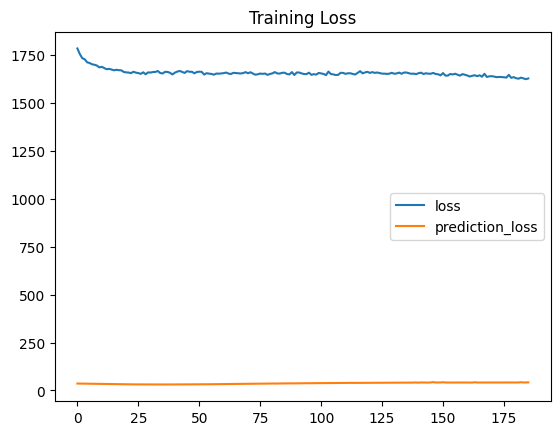

100%|██████████| 866/866 [00:49<00:00, 17.45it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 26.9481 20.8720 20.8720
Cyclist AP@0.5: 18.1818 55.5024 55.5024
Car AP@0.7: 90.1677 85.6803 83.3065
==========AOS==========
Pedestrian AOS@0.5: 2.5570 2.2968 2.2968
Cyclist AOS@0.5: 14.1382 49.3900 49.3900
Car AOS@0.7: 90.3669 87.6190 86.6341
==========BBOX_BEV==========
Pedestrian AP@0.5: 56.2771 42.8571 42.8571
Cyclist AP@0.5: 18.1818 40.1914 40.1914
Car AP@0.7: 87.6166 81.9944 70.8648
==========BBOX_3D==========
Pedestrian AP@0.5: 41.6667 30.8905 30.8905
Cyclist AP@0.5: 13.6364 30.1435 30.1435
Car AP@0.7: 69.8488 55.6612 53.0931

==========Overall==========
bbox_2d AP: 45.0992 54.0182 53.2269
AOS AP: 35.6874 46.4353 46.1070
bbox_bev AP: 54.0252 55.0143 51.3045
bbox_3d AP: 41.7173 38.8984 38.0424


100%|██████████| 866/866 [01:20<00:00, 10.78it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 656 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 18.9394 13.3581 13.3581
Cyclist AP@0.5: 15.9091 28.7081 28.7081
Car AP@0.7: 42.3817 37.8564 36.8878
==========AOS==========
Pedestrian AOS@0.5: 1.8625 1.5962 1.5962
Cyclist AOS@0.5: 1.0072 4.5873 4.5873
Car AOS@0.7: 31.7947 26.7963 27.0773
==========BBOX_BEV==========
Pedestrian AP@0.5: 18.6688 12.8015 12.8015
Cyclist AP@0.5: 15.9091 11.0048 11.0048
Car AP@0.7: 49.9955 29.9830 28.3890
==========BBOX_3D==========
Pedestrian AP@0.5: 12.3377 10.5751 10.5751
Cyclist AP@0.5: 3.4091 5.0239 5.0239
Car AP@0.7: 18.8196 12.2931 11.6195

==========Overall==========
bbox_2d AP: 25.7434 26.6409 26.3180
AOS AP: 11.5548 10.9933 11.0869
bbox_bev AP: 28.1911 17.9297 17.3984
bbox_3d AP: 11.5221 9.2974 9.0728
==================== 186 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 187 ====================


100%|██████████| 1755/1755 [19:22<00:00,  1.51it/s]


==================== 188 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 189 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


==================== 190 ====================


100%|██████████| 1755/1755 [19:21<00:00,  1.51it/s]


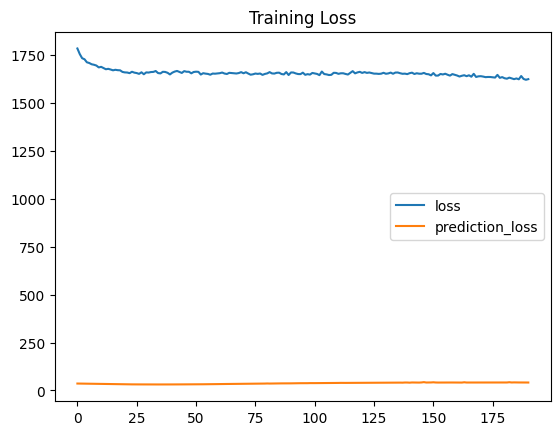

100%|██████████| 866/866 [00:50<00:00, 17.10it/s]


Evaluating Exact results.. Please wait several seconds.
==========BBOX_2D==========
Pedestrian AP@0.5: 12.5541 11.6883 11.6883
Cyclist AP@0.5: 18.1818 66.7464 66.7464
Car AP@0.7: 99.5050 86.5136 84.5142
==========AOS==========
Pedestrian AOS@0.5: 8.5904 7.2818 7.2818
Cyclist AOS@0.5: 3.8930 37.1692 37.1692
Car AOS@0.7: 97.9852 87.3044 86.7314
==========BBOX_BEV==========
Pedestrian AP@0.5: 19.2100 17.3933 17.3933
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 85.6886 81.6063 70.8925
==========BBOX_3D==========
Pedestrian AP@0.5: 6.8182 6.2616 6.2616
Cyclist AP@0.5: 18.1818 30.8612 30.8612
Car AP@0.7: 71.5302 64.7572 54.6741

==========Overall==========
bbox_2d AP: 43.4136 54.9828 54.3163
AOS AP: 36.8228 43.9185 43.7275
bbox_bev AP: 41.0268 50.8627 47.2915
bbox_3d AP: 32.1767 33.9600 30.5990


100%|██████████| 866/866 [01:20<00:00, 10.71it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 652 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 12.5541 11.1317 11.1317
Cyclist AP@0.5: 11.3636 43.2727 43.2727
Car AP@0.7: 53.0634 40.1021 38.7603
==========AOS==========
Pedestrian AOS@0.5: 1.8582 1.9067 1.9067
Cyclist AOS@0.5: 2.3006 19.1309 19.1309
Car AOS@0.7: 45.9687 36.4666 35.5167
==========BBOX_BEV==========
Pedestrian AP@0.5: 13.2035 12.0594 12.0594
Cyclist AP@0.5: 13.6364 17.3445 17.3445
Car AP@0.7: 50.5992 29.5609 28.3185
==========BBOX_3D==========
Pedestrian AP@0.5: 6.1688 5.4267 5.4267
Cyclist AP@0.5: 4.5455 5.7416 5.7416
Car AP@0.7: 20.0971 12.9046 12.2007

==========Overall==========
bbox_2d AP: 25.6604 31.5022 31.0549
AOS AP: 16.7092 19.1681 18.8514
bbox_bev AP: 25.8130 19.6549 19.2408
bbox_3d AP: 10.2705 8.0243 7.7897
==================== 191 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


==================== 192 ====================


100%|██████████| 1755/1755 [19:21<00:00,  1.51it/s]


==================== 193 ====================


100%|██████████| 1755/1755 [19:22<00:00,  1.51it/s]


==================== 194 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 195 ====================


100%|██████████| 1755/1755 [19:24<00:00,  1.51it/s]


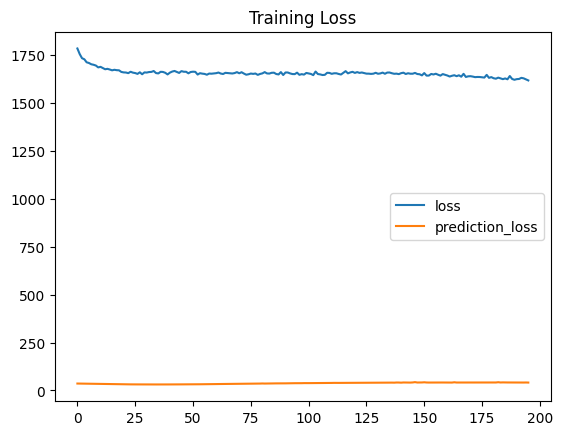

100%|██████████| 866/866 [00:50<00:00, 17.29it/s]


Evaluating Exact results.. Please wait several seconds.
Validation failed


100%|██████████| 866/866 [01:21<00:00, 10.65it/s]


Evaluating Estimated results.. Please wait several seconds.
Gating count = 648 out of 866
==========BBOX_2D==========
Pedestrian AP@0.5: 31.1688 27.5510 27.5510
Cyclist AP@0.5: 13.6364 37.6794 37.6794
Car AP@0.7: 53.7419 40.3406 38.8153
==========AOS==========
Pedestrian AOS@0.5: 5.1467 4.4711 4.4711
Cyclist AOS@0.5: 0.7322 2.5815 2.5815
Car AOS@0.7: 47.2614 37.9036 37.2678
==========BBOX_BEV==========
Pedestrian AP@0.5: 29.8701 26.4378 26.4378
Cyclist AP@0.5: 13.6364 11.0048 11.0048
Car AP@0.7: 51.6844 30.3927 28.8608
==========BBOX_3D==========
Pedestrian AP@0.5: 13.6364 12.2449 12.2449
Cyclist AP@0.5: 11.3636 5.7416 5.7416
Car AP@0.7: 19.2989 12.3347 11.5636

==========Overall==========
bbox_2d AP: 32.8490 35.1903 34.6819
AOS AP: 17.7135 14.9854 14.7735
bbox_bev AP: 31.7303 22.6118 22.1011
bbox_3d AP: 14.7663 10.1071 9.8500
==================== 196 ====================


100%|██████████| 1755/1755 [19:20<00:00,  1.51it/s]


==================== 197 ====================


100%|██████████| 1755/1755 [19:25<00:00,  1.51it/s]


==================== 198 ====================


100%|██████████| 1755/1755 [19:21<00:00,  1.51it/s]


==================== 199 ====================


100%|██████████| 1755/1755 [19:23<00:00,  1.51it/s]


In [11]:

epoch0 = 0
global_step=0

for epoch in range(epoch0, args.max_epoch):
# for epoch in range(1):
    epoch_loss0 = 0
    epoch_gLoss0 = 0

    train_indices = np.random.randint(train_dataset_length, size=train_dataset_batch_count)

    print('=' * 20, epoch, '=' * 20)

    train_step, val_step = 0, 0

    pointpillars.train()

    for step in tqdm(range(train_dataset_batch_count)):
    # for step in tqdm(range(10)):

        optimizer.zero_grad()

        # Load data
        data = train_dataset.__getitem__(train_indices[step])
        data_cuda = [send_to_cuda(d) for d in data]

        if step % 2 == 0:
            estimation_flag=False
        else:
            estimation_flag=True
        # Forward Pass
        results = pointpillars(data_cuda, mode='train', estimation_flag=estimation_flag)

        # Matching etc and loss compute
        loss_dict, gLoss = measure_losses(results)

        # Backpropagation
        lambda_g = 0.0002

        loss0 = loss_dict['total_loss']
        loss = loss0  + lambda_g*gLoss
        loss.backward()

        epoch_loss0 = epoch_loss0 + loss0.item()
        epoch_gLoss0 = epoch_gLoss0 + lambda_g*gLoss

        # torch.nn.utils.clip_grad_norm_(pointpillars.parameters(), max_norm=35)
        optimizer.step()
        scheduler.step()
        train_step += 1

        global_step = 2*train_dataset_batch_count*epoch + train_step

        if global_step==0:
            model_flag=True
        # if global_step % args.log_freq == 0:
        #     save_summary(writer, loss_dict, global_step, 'train', p,
        #                     lr=optimizer.param_groups[0]['lr'], 
        #                     momentum=optimizer.param_groups[0]['betas'][0],
        #                     model=pointpillars, data=data_cuda, flag=model_flag)

    training_loss0.append(epoch_loss0)
    training_gLoss0.append(epoch_gLoss0.detach().cpu())

    if epoch % args.ckpt_freq_epoch == 0:

        checkpoint = {
        'epoch': epoch,
        'model_state_dict': pointpillars.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }   
        torch.save(checkpoint, os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth.tar'))
    ###################################### Validation ######################################

    if (epoch % args.val_freq_epoch) == 0 and epoch >0:
    # if (epoch % args.val_freq_epoch) == 0:

        plt.figure()
        plt.plot(np.array(training_loss0))
        plt.plot(np.array(training_gLoss0))
        plt.title("Training Loss")
        plt.legend(["loss", "prediction_loss"])
        plt.show()

        pointpillars.eval()

        with torch.no_grad():

            ######################## validation with exact ##############################
            format_results = {}

            for step in tqdm(range(val_dataset_length)):

                # Load data
                data = val_dataset.__getitem__(step)
                data_cuda = [send_to_cuda(d) for d in data]

                # Forward Pass
                results = pointpillars(data_cuda, mode='val_exact')

                try:
                    format_result, idx = validation_writer(results, data_cuda)
                    write_label(format_result, os.path.join(saved_submit_path_exact, f'{idx:06d}.txt'))
                    format_results[idx] = {k:np.array(v) for k, v in format_result.items()}
                except:
                    continue

            write_pickle(format_results, os.path.join(saved_path_exact, 'results.pkl'))

            print('Evaluating Exact results.. Please wait several seconds.')
            try:
                do_eval(format_results, val_dataset.data_infos, CLASSES, saved_path_exact)
            except:
                print("Validation failed")

            ######################## validation with estimation ##############################
            
            format_results = {}

            first_velodyne_path = val_dataset.data_infos[val_dataset.sorted_ids[0]]['velodyne_path']
            validation_sequence = get_sequence_from_velodyne_path(first_velodyne_path)
            pointpillars.gating_count = 0

            for step in tqdm(range(val_dataset_length)):

                # Load data
                data = val_dataset.__getitem__(step)
                data_cuda = [send_to_cuda(d) for d in data]

                current_velodyne_path = val_dataset.data_infos[val_dataset.sorted_ids[step]]['velodyne_path']
                current_validation_sequence = get_sequence_from_velodyne_path(current_velodyne_path)
                
                if current_validation_sequence != validation_sequence or step==0:
                    retain_memory = False
                    validation_sequence = current_validation_sequence
                else:
                    retain_memory = True

                # Forward Pass
                results = pointpillars(data_cuda, mode='val_estimate', memory=retain_memory)

                try: 
                    format_result, idx = validation_writer(results, data_cuda)
                    write_label(format_result, os.path.join(saved_submit_path_estimate, f'{idx:06d}.txt'))
                    format_results[idx] = {k:np.array(v) for k, v in format_result.items()}
                except:
                    None

            try:
                write_pickle(format_results, os.path.join(saved_path_estimate, 'results.pkl'))
            except:
                None

            print('Evaluating Estimated results.. Please wait several seconds.')
            print("Gating count = " + str(pointpillars.gating_count) + " out of " + str(val_dataset_length))

            try:
                do_eval(format_results, val_dataset.data_infos, CLASSES, saved_path_estimate)
                
            except:
                print("Validation failed")

        

In [13]:

'''
==========BBOX_2D==========
Pedestrian AP@0.5: 12.5541 12.0594 12.0594
Cyclist AP@0.5: 18.1818 67.8230 67.8230
Car AP@0.7: 90.3473 85.0690 82.6321
==========AOS==========
Pedestrian AOS@0.5: 2.2431 1.8547 1.8547
Cyclist AOS@0.5: 0.0884 9.7744 9.7744
Car AOS@0.7: 90.1198 88.3073 86.8500
==========BBOX_BEV==========
Pedestrian AP@0.5: 17.3160 12.9870 12.9870
Cyclist AP@0.5: 18.1818 53.5885 53.5885
Car AP@0.7: 86.9970 81.8544 71.0886
==========BBOX_3D==========
Pedestrian AP@0.5: 11.4719 10.9462 10.9462
Cyclist AP@0.5: 18.1818 28.7081 28.7081
Car AP@0.7: 71.3308 56.4050 53.9020

==========Overall==========
bbox_2d AP: 40.3611 54.9838 54.1715
AOS AP: 30.8171 33.3121 32.8263
bbox_bev AP: 40.8316 49.4766 45.8880
bbox_3d AP: 33.6615 32.0198 31.1854


==========BBOX_2D==========
Pedestrian AP@0.5: 12.3377 11.1317 11.1317
Cyclist AP@0.5: 3.4091 39.3541 39.3541
Car AP@0.7: 71.9899 55.0626 53.1738
==========AOS==========
Pedestrian AOS@0.5: 2.9628 2.4612 2.4612
Cyclist AOS@0.5: 0.0064 2.0339 2.0339
Car AOS@0.7: 74.2191 63.3802 62.0901
==========BBOX_BEV==========
Pedestrian AP@0.5: 10.1732 6.8182 6.8182
Cyclist AP@0.5: 3.4091 11.9617 11.9617
Car AP@0.7: 57.2220 39.6281 37.3518
==========BBOX_3D==========
Pedestrian AP@0.5: 5.1948 3.1540 3.1540
Cyclist AP@0.5: 3.4091 5.7416 5.7416
Car AP@0.7: 39.7968 26.3120 20.4752

==========Overall==========
bbox_2d AP: 29.2456 35.1828 34.5532
AOS AP: 25.7295 22.6251 22.1951
bbox_bev AP: 23.6014 19.4693 18.7106
bbox_3d AP: 16.1336 11.7359 9.7903
'''

'\n==========BBOX_2D==========\nPedestrian AP@0.5: 12.5541 12.0594 12.0594\nCyclist AP@0.5: 18.1818 67.8230 67.8230\nCar AP@0.7: 90.3473 85.0690 82.6321\n==========AOS==========\nPedestrian AOS@0.5: 2.2431 1.8547 1.8547\nCyclist AOS@0.5: 0.0884 9.7744 9.7744\nCar AOS@0.7: 90.1198 88.3073 86.8500\n==========BBOX_BEV==========\nPedestrian AP@0.5: 17.3160 12.9870 12.9870\nCyclist AP@0.5: 18.1818 53.5885 53.5885\nCar AP@0.7: 86.9970 81.8544 71.0886\n==========BBOX_3D==========\nPedestrian AP@0.5: 11.4719 10.9462 10.9462\nCyclist AP@0.5: 18.1818 28.7081 28.7081\nCar AP@0.7: 71.3308 56.4050 53.9020\n\n==========Overall==========\nbbox_2d AP: 40.3611 54.9838 54.1715\nAOS AP: 30.8171 33.3121 32.8263\nbbox_bev AP: 40.8316 49.4766 45.8880\nbbox_3d AP: 33.6615 32.0198 31.1854\n'

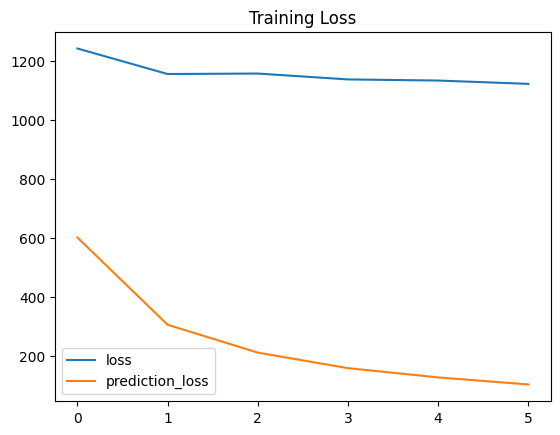

In [14]:

    #     global_step = epoch * len(train_dataloader) + train_step + 1

    #     if global_step % args.log_freq == 0:
    #         save_summary(writer, loss_dict0, global_step, 'train',
    #                         lr=optimizer.param_groups[0]['lr'], 
    #                         momentum=optimizer.param_groups[0]['betas'][0])
    #     train_step += 1

    # training_loss0.append(epoch_loss0)
    # training_gLoss0.append(epoch_gLoss0.detach().cpu())

    # if epoch % 2 == 0:
    #     continue

    # pointpillars.eval()
    # with torch.no_grad():
    #     for i, data_dict in enumerate(tqdm(val_dataloader)):
    #         try:
    #             if not args.no_cuda:
    #                 # move the tensors to the cuda
    #                 for key in data_dict:
    #                     for j, item in enumerate(data_dict[key]):
    #                         if torch.is_tensor(item):
    #                             data_dict[key][j] = data_dict[key][j].cuda()
                
    #             batched_pts = data_dict['batched_pts']
    #             batched_gt_bboxes = data_dict['batched_gt_bboxes']
    #             batched_labels = data_dict['batched_labels']
    #             batched_difficulty = data_dict['batched_difficulty']

    #             bbox_cls_pred0, bbox_pred0, bbox_dir_cls_pred0, anchor_target_dict, x, xe = pointpillars(batched_pts=batched_pts, 
    #                                         batched_pts0=batched_pts0, 
    #                                         mode='train',
    #                                         batched_gt_bboxes=batched_gt_bboxes, 
    #                                         batched_gt_labels=batched_labels)\
    #                 # bbox_cls_pred1, bbox_pred1, bbox_dir_cls_pred1, \
    #                 #     bbox_cls_pred2, bbox_pred2, bbox_dir_cls_pred2,  = \

                
    #             ################# Full features #################
    #             bbox_cls_pred0 = bbox_cls_pred0.permute(0, 2, 3, 1).reshape(-1, args.nclasses)
    #             bbox_pred0 = bbox_pred0.permute(0, 2, 3, 1).reshape(-1, 7)
    #             bbox_dir_cls_pred0 = bbox_dir_cls_pred0.permute(0, 2, 3, 1).reshape(-1, 2)



    #             batched_bbox_labels = anchor_target_dict['batched_labels'].reshape(-1)
    #             batched_label_weights = anchor_target_dict['batched_label_weights'].reshape(-1)
    #             batched_bbox_reg = anchor_target_dict['batched_bbox_reg'].reshape(-1, 7)
    #             batched_dir_labels = anchor_target_dict['batched_dir_labels'].reshape(-1)


                
    #             pos_idx = (batched_bbox_labels >= 0) & (batched_bbox_labels < args.nclasses)

    #             bbox_pred0 = bbox_pred0[pos_idx]


    #             batched_bbox_reg = batched_bbox_reg[pos_idx]
    #             batched_bbox_reg0 = batched_bbox_reg.clone()

    #             # sin(a - b) = sin(a)*cos(b) - cos(a)*sin(b)
    #             bbox_pred0[:, -1] = torch.sin(bbox_pred0[:, -1].clone()) * torch.cos(batched_bbox_reg[:, -1].clone())
    #             batched_bbox_reg0[:, -1] = torch.cos(bbox_pred0[:, -1].clone()) * torch.sin(batched_bbox_reg[:, -1].clone())
    #             bbox_dir_cls_pred0 = bbox_dir_cls_pred0[pos_idx]
    #             batched_dir_labels = batched_dir_labels[pos_idx]
    #             num_cls_pos = (batched_bbox_labels < args.nclasses).sum()
    #             bbox_cls_pred0 = bbox_cls_pred0[batched_label_weights > 0]


    #             batched_bbox_labels[batched_bbox_labels < 0] = args.nclasses
    #             batched_bbox_labels = batched_bbox_labels[batched_label_weights > 0]

    #             loss_dict0 = loss_func(bbox_cls_pred=bbox_cls_pred0,
    #                                     bbox_pred=bbox_pred0,
    #                                     bbox_dir_cls_pred=bbox_dir_cls_pred0,
    #                                     batched_labels=batched_bbox_labels, 
    #                                     num_cls_pos=num_cls_pos, 
    #                                     batched_bbox_reg=batched_bbox_reg0, 
    #                                     batched_dir_labels=batched_dir_labels)
                
                
    #             loss0 = loss_dict0['total_loss'] 
                
    #             gLoss = torch.norm(x-xe)


    #             if not np.isnan(loss0.item()):
    #                 val_epoch_loss0 = val_epoch_loss0 + loss0.item()
    #                 val_epoch_gLoss0 = val_epoch_gLoss0 + lambda_g*gLoss


    #             else:
    #                 continue

    #             global_step = epoch * len(val_dataloader) + val_step + 1
    #             if global_step % args.log_freq == 0:
    #                 save_summary(writer, loss_dict0, global_step, 'val')
    #             val_step += 1
            
    #         except:
    #             None

    # val_loss0.append(val_epoch_loss0)
    # val_gLoss0.append(val_epoch_gLoss0.detach().cpu())
            
    # pointpillars.train()

    # if (epoch + 1) % args.ckpt_freq_epoch == 0:
    #     torch.save(pointpillars.state_dict(), os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth'))
    #     checkpoint = {
    #     'epoch': epoch,
    #     'model_state_dict': pointpillars.state_dict(),
    #     'optimizer_state_dict': optimizer.state_dict(),
    #     'loss': loss
    #     }   
    #     torch.save(checkpoint, os.path.join(saved_ckpt_path, f'epoch_{epoch+1}.pth.tar'))
    #     np.save(os.path.join(saved_ckpt_path, f'train_loss.npy'), np.array(training_loss0))
    #     np.save(os.path.join(saved_ckpt_path, f'train_gloss.npy'), np.array(training_gLoss0))
    #     np.save(os.path.join(saved_ckpt_path, f'val_loss.npy'), np.array(val_loss0))
    #     np.save(os.path.join(saved_ckpt_path, f'val_gloss.npy'), np.array(val_gLoss0))

    # if (epoch + 1) % args.plot_freq_epoch == 0:

plt.figure()
plt.plot(np.array(training_loss0))
plt.plot(np.array(training_gLoss0)*0.01)
plt.title("Training Loss")
plt.legend(["loss", "prediction_loss"])
plt.show()

    #     plt.figure()
    #     plt.plot(np.array(val_loss0))
    #     plt.plot(np.array(val_gLoss0))
    #     plt.title("Validation Loss")
    #     plt.legend(["loss","prediction_loss"])
    #     plt.show()